## Импорт модулей

Import PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import torch.optim as optim
from torchsummary import summary

from torch.utils.data import Dataset, DataLoader, random_split

from torch.amp import autocast
from torch.cuda.amp import GradScaler

Графика и отображение

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from tqdm import tqdm

Numpy, метрики, работа с файлами

In [3]:
import os
import numpy as np
import json
import shutil
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from early_stopping_pytorch import EarlyStopping
from torch.utils.data.sampler import WeightedRandomSampler

## Переменные и настройки

In [ ]:
class_names = ['0-12', '13-25', '26-60', '60+']
img_dir = r"F:\crop_part_big2"  # Путь к директории изображений

EPOCH = 250
image_size = (200, 200)     # Размер изображений
batch_size = 47             # Размер батча обучающего
batch_size_val = 20             # Размер батча валидационного
train_size_persent = 0.85       # Процент обучающей выборки

web_path_dir = r"PATH"
save_metrix_img = False
Print_matrix_in_console = False

show_satsts_sataset = True
shutdown = True # отменить os.system("shutdown -a")

Проверка, доступен ли GPU

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
CUDA version: 11.7
GPU: NVIDIA GeForce RTX 3090


Функции для визуализации

In [ ]:
# Отоюражение примеров картинок во время предобработки
def show_image_from_loader(loader, title):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    # Показ первого изображения из пакета
    image = images[0].permute(1, 2, 0).numpy() * 0.5 + 0.5  # Денормализация для визуализации
    plt.imshow(image)
    plt.title(f"{title} - Age Group: {labels[0].item()}")
    plt.axis('off')
    plt.show()


# Матрица ошибок после обучения 
def plot_confusion_matrix(cm, class_names=None, figsize=(10, 8), cmap='Blues', title='Матрица ошибок', save = True): 
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.title(title)
    plt.tight_layout()
    if save:
        plt.savefig('confusion_matrix.png')
    plt.show()



# Функция построения графиков метрик
def plotter(train_losses, val_losses, train_accuracies, val_accuracies, 
            train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s,
            save=False, plot_dir="plot"):

    def to_cpu_numpy(data):
        if isinstance(data, torch.Tensor):
            return data.detach().cpu().numpy()
        return data

    train_losses = [to_cpu_numpy(t) for t in train_losses]
    val_losses = [to_cpu_numpy(t) for t in val_losses]
    train_accuracies = [to_cpu_numpy(t) for t in train_accuracies]
    val_accuracies = [to_cpu_numpy(t) for t in val_accuracies]
    train_precisions = [to_cpu_numpy(t) for t in train_precisions]
    val_precisions = [to_cpu_numpy(t) for t in val_precisions]
    train_recalls = [to_cpu_numpy(t) for t in train_recalls]
    val_recalls = [to_cpu_numpy(t) for t in val_recalls]
    train_f1s = [to_cpu_numpy(t) for t in train_f1s]
    val_f1s = [to_cpu_numpy(t) for t in val_f1s]
    
    if save:
        if save and not os.path.exists(plot_dir):
            os.makedirs(plot_dir)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(os.path.join(plot_dir, "accuracy.png"))
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(os.path.join(plot_dir, "loss.png"))
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_precisions, label='Train Precision')
    plt.plot(val_precisions, label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(os.path.join(plot_dir, "precision.png"))
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.plot(train_recalls, label='Train Recall')
    plt.plot(val_recalls, label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(os.path.join(plot_dir, "recall.png"))
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_f1s, label='Train F1 Score')
    plt.plot(val_f1s, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(os.path.join(plot_dir, "f1_score.png"))
    plt.show()

Функции для вывода в веб морду

In [ ]:
def save_metrics(train_metrics, val_metrics, additional_information=None, filepath='metrics.json', append=True):

    # Функция для преобразования numpy arrays в JSON
    def convert_to_serializable(item):
        if isinstance(item, np.ndarray):
            return item.tolist()
        elif isinstance(item, list):
            return [convert_to_serializable(i) for i in item]
        elif isinstance(item, dict):
            return {k: convert_to_serializable(v) for k, v in item.items()}
        elif isinstance(item, (np.int64, np.int32, np.int16, np.int8)):
            return int(item)
        elif isinstance(item, (np.float64, np.float32, np.float16)):
            return float(item)
        else:
            return item
    
    train_metrics_copy = convert_to_serializable(train_metrics)
    val_metrics_copy = convert_to_serializable(val_metrics)
    additional_info_copy = convert_to_serializable(additional_information) if additional_information else {}
    
    # Создаем общий словарь для сохранения
    metrics_dict = {
        'train': train_metrics_copy,
        'validation': val_metrics_copy,
        'additional_information': additional_info_copy
    }
    
    # Если append=True и файл существует, дополняем данные
    if append and os.path.exists(filepath):
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                existing_metrics = json.load(f)
                
            for split in ['train', 'validation']:
                if split not in existing_metrics:
                    existing_metrics[split] = {}
                    
                for metric_name, metric_values in (metrics_dict[split]).items():
                    if metric_name in existing_metrics[split]:
                        if metric_name in ['confusion_matrix', 'confusion_matrix_norm']:
                            existing_metrics[split][metric_name] = metric_values
                        elif isinstance(metric_values, list) and isinstance(existing_metrics[split][metric_name], list):
                            existing_metrics[split][metric_name].extend(metric_values)
                        else:
                            existing_metrics[split][metric_name] = metric_values
                    else:
                        existing_metrics[split][metric_name] = metric_values
            
            # Обновление дополнительной информации
            if 'additional_information' not in existing_metrics:
                existing_metrics['additional_information'] = {}
                
            if additional_info_copy:
                for key, value in additional_info_copy.items():
                    if key in existing_metrics['additional_information'] and isinstance(value, list):
                        if isinstance(existing_metrics['additional_information'][key], list):
                            existing_metrics['additional_information'][key].extend(value)
                        else:
                            existing_metrics['additional_information'][key] = [existing_metrics['additional_information'][key]] + value
                    else:
                        existing_metrics['additional_information'][key] = value
            
            metrics_dict = existing_metrics
                
        except (json.JSONDecodeError, FileNotFoundError) as e:
            print(f"Ошибка при чтении существующего файла: {e}")
            print("Создается новый файл метрик")
    
    # Сохраняем обновленные метрики в файл
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(metrics_dict, f, ensure_ascii=False, indent=4)
    
    if append:
        print(f"Метрики успешно добавлены в {filepath}")
    else:
        print(f"Метрики успешно перезаписаны в {filepath}")

def clear_folder(folder_path='folder'):
    try:
        if not os.path.exists(folder_path):
            print(f"Папка {folder_path} не существует. Создаем новую.")
            os.makedirs(folder_path)
        
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
                print(f"Удален файл: {file_path}")
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
                print(f"Удалена папка: {file_path}")
        
        print(f"Папка {folder_path} успешно очищена")
        
    except Exception as e:
        print(f"Ошибка при очистке папки {folder_path}: {e}")
        #return False

clear_folder(web_path_dir.replace("\metrics.json",""))

Удален файл: C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json
Папка C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data успешно очищена


## Предобработка данных и подготовка датасета

Разлеление датасета на классы и взвешивание - class weights

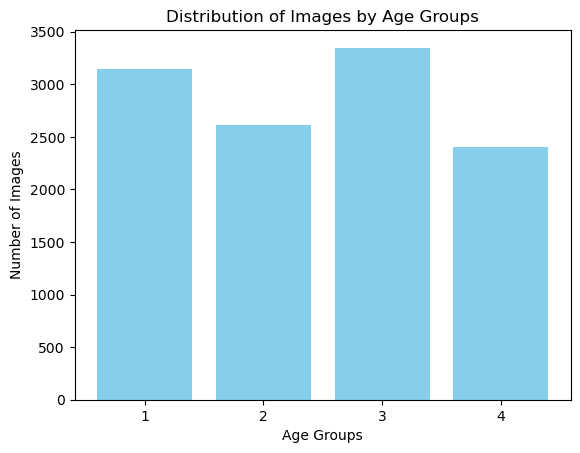

[3145, 2613, 3347, 2407]
Class_counts: [3145, 2613, 3347, 2407]
Class weights: tensor([0.8989, 1.0819, 0.8447, 1.1745])


In [8]:
# Функция для определения возрастной группы
def get_age_group(age):
    if age < 12:
        return 0  # Группа 1: < 12
    elif 13 <= age < 25:
        return 1  # Группа 2: 20-39
    elif 26 <= age < 60:
        return 2  # Группа 3: 40-59
    else:
        return 3  # Группа 4: 60+

# Собираем данные для групп
age_group_counts = [0, 0, 0, 0]  # Для 4 возрастных групп
# Проходим по файлам в директории и считаем количество изображений в каждой группе
for img_name in os.listdir(img_dir):
    if img_name.endswith(".jpg"):  # Убедимся, что это изображение
        age = int(img_name.split('_')[0])
        age_group = get_age_group(age)
        age_group_counts[age_group] += 1

# Отобразим распределение данных по группам
age_groups = ['1', '2', '3', '4']
plt.bar(age_groups, age_group_counts, color='skyblue')
plt.xlabel('Age Groups')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Age Groups')
plt.show()
print(age_group_counts)

class_counts = age_group_counts
print(f"Class_counts: {class_counts}")
# Рассчитываем веса как обратные значения частоты каждого класса
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
# Нормализация весов так, чтобы их сумма была равна количеству классов
class_weights = class_weights / class_weights.sum() * len(class_weights)
print("Class weights:", class_weights)

# class_weights = torch.tensor([0.8889, 1.0519, 0.8747, 1.1745])
# print("Class weights_UP:", class_weights)

class_weights = class_weights.to(device)

Предобработка данных, Аугментация, Созадание DataLoader

In [9]:
# Функция для one-hot кодирования метки
def one_hot_encode(label, num_classes=4):
    return torch.eye(num_classes)[label]

# Кастомный датасет для загрузки изображений
class AgeDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = []

        # Собираем список всех изображений и их метки
        for img_name in os.listdir(img_dir):
            if img_name.endswith(".jpg"):  # Убедимся, что это изображение
                # Извлекаем возраст из имени файла
                age = int(img_name.split('_')[0])
                age_group = get_age_group(age)
                self.img_labels.append((img_name, age_group))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name, label = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        # Преобразуем метку в one-hot encoding
        #label = one_hot_encode(label, num_classes=4)

        return image, label

# Трансформации для изображений
transform = transforms.Compose([
    transforms.Resize(image_size),  # Изменение размера
    transforms.RandomHorizontalFlip(p=0.5),  # Случайное горизонтальное отражение
    transforms.RandomRotation(degrees=15),  # Случайный поворот в пределах [-15, 15] градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Рандомная настройка цвета
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Случайное смещение
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Случайная перспектива
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


dataset = AgeDataset(img_dir, transform=transform)

# Делим датасет на тренировочную и валидационную выборки
train_size = int(train_size_persent * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
# Функция для подсчета количества экземпляров каждого класса
def count_labels(dataset):
    labels_count = {0: 0, 1: 0, 2: 0, 3: 0}
    
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        labels_count[label] += 1
    
    return labels_count

if show_satsts_sataset:
    # Подсчет для тренировочного датасета
    train_labels_count = count_labels(train_dataset)
    print("Распределение классов в Train Dataset:")
    for class_idx, count in train_labels_count.items():
        print(f"Класс {class_idx}: {count} изображений")

    # Подсчет для валидационного датасета
    val_labels_count = count_labels(val_dataset)
    print("\nРаспределение классов в Validation Dataset:")
    for class_idx, count in val_labels_count.items():
        print(f"Класс {class_idx}: {count} изображений")

    # Общая статистика
    total_train = sum(train_labels_count.values())
    total_val = sum(val_labels_count.values())
    print("\nВсего изображений в тренировочном датасете:", total_train)
    print("Всего изображений в валидационном датасете:", total_val)
    print("Общее количество изображений:", total_train + total_val)

Распределение классов в Train Dataset:
Класс 0: 2669 изображений
Класс 1: 2222 изображений
Класс 2: 2844 изображений
Класс 3: 2050 изображений

Распределение классов в Validation Dataset:
Класс 0: 476 изображений
Класс 1: 391 изображений
Класс 2: 503 изображений
Класс 3: 357 изображений

Всего изображений в тренировочном датасете: 9785
Всего изображений в валидационном датасете: 1727
Общее количество изображений: 11512


Балансировщик тренироваочного датасета

In [ ]:
# Получаем список меток для train
train_indices = train_dataset.indices
train_labels = [dataset.img_labels[i][1] for i in train_indices]

train_weights = [class_weights[label].item() for label in train_labels]

# Создаем взвешенный sampler
train_sampler = WeightedRandomSampler(
    weights=train_weights,
    num_samples=len(train_weights),
    replacement=True  # Включаем повторную выборку для компенсации дисбаланса
)

Создаем DataLoader для тренировочной и валидационной выборок

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,  # Используем взвешенный sampler
    shuffle=False,          # Отключаем стандартный shuffle
    pin_memory=True 
)

val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

Проверка подготовленных данных

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


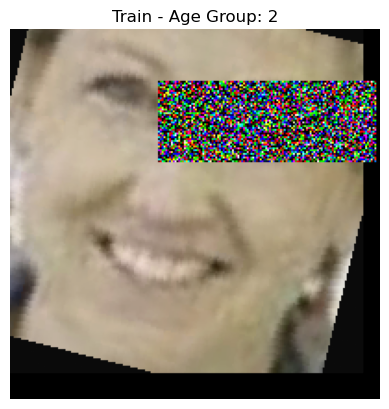

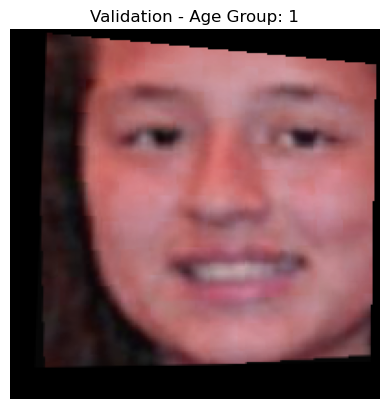

In [13]:
show_image_from_loader(train_loader, "Train")
show_image_from_loader(val_loader, "Validation")

## Создание модели 

Механизм внимания CBAM

In [14]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

# Модуль CBAM (Channel + Spatial Attention)
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(in_channels, ratio=reduction)
        self.spatial_att = SpatialAttention()
        
    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

Residual Block

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, reduction=16):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.cbam = CBAM(out_channels, reduction=reduction)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.leaky_relu(self.bn1(self.conv1(x)))
        out = F.leaky_relu(self.bn2(self.conv2(out)))
        out = self.cbam(out)
        out += identity
        out = F.leaky_relu(out)
        return out

Построение модели

In [ ]:
class My_Model(nn.Module):
    def __init__(self, num_classes=4):
        super(My_Model, self).__init__()
        
        # Часть для извлечения признаков (features)
        self.features = Features()
        
        # Классификатор
        self.classifier = Classifier(num_classes=num_classes)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class Features(nn.Module):
    def __init__(self):
        super(Features, self).__init__()
        
        self.residual1 = ResidualBlock(in_channels=3, out_channels=256, reduction=32, kernel_size=5, stride=1, padding=2)
        self.residual2 = ResidualBlock(in_channels=256, out_channels=128, reduction=16)
        self.residual3 = ResidualBlock(in_channels=128, out_channels=64, reduction=8)
        self.residual4 = ResidualBlock(in_channels=64, out_channels=32, reduction=8)
        self.residual5 = ResidualBlock(in_channels=32, out_channels=16, reduction=4)
        self.residual6 = ResidualBlock(in_channels=16, out_channels=16, reduction=4)
        self.residual7 = ResidualBlock(in_channels=16, out_channels=16, reduction=4)
        
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.cbam1 = CBAM(16, reduction=4)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.cbam2 = CBAM(16, reduction=4)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.cbam3 = CBAM(16, reduction=4)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.pool(self.residual1(x))
        x = self.pool(self.residual2(x))
        x = self.pool(self.residual3(x))
        x = self.pool(self.residual4(x))
        x = self.pool(self.residual5(x))
        x = self.residual6(x)
        x = self.residual7(x)
        
        x = F.relu(self.bn1(self.cbam1(self.conv1(x))))
        x = F.relu(self.bn2(self.cbam2(self.conv2(x))))
        x = F.relu(self.bn3(self.cbam3(self.conv3(x))))
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        return x

class Classifier(nn.Module):
    def __init__(self, num_classes=4):
        super(Classifier, self).__init__()
        
        self.drop_0 = nn.Dropout(0.3)
        self.fc0 = nn.Linear(16, 16)
        self.drop_1 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(16, num_classes)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.drop_0(x)
        x = self.fc0(x)
        x = self.drop_1(x)
        x = self.fc1(x)
        
        return x

Инициализация модели, загрузка на устройство, проверка

In [17]:
model = My_Model().to(device)
summary(model, input_size=(3,image_size[0], image_size[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 200, 200]           1,024
       BatchNorm2d-2        [-1, 256, 200, 200]             512
            Conv2d-3        [-1, 256, 200, 200]          19,456
       BatchNorm2d-4        [-1, 256, 200, 200]             512
            Conv2d-5        [-1, 256, 200, 200]       1,638,656
       BatchNorm2d-6        [-1, 256, 200, 200]             512
 AdaptiveAvgPool2d-7            [-1, 256, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]           2,048
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10            [-1, 256, 1, 1]           2,048
AdaptiveMaxPool2d-11            [-1, 256, 1, 1]               0
           Conv2d-12              [-1, 8, 1, 1]           2,048
             ReLU-13              [-1, 8, 1, 1]               0
           Conv2d-14            [-1, 25

## Обучение

Вспомогательные функции

In [ ]:
# Функция отображения Матрицы ошибок текстом в цикле обучения
def print_confusion_matrix(cm, class_names=None, num_classes=None, show_original=False):
    if class_names is not None:
        header = "       " + " ".join([f"{name:<10}" for name in class_names])
        print(header)
        for i, row in enumerate(cm):
            print(f"{class_names[i]:<7}" + " ".join([f"{val:<10}" for val in row]))
    else:
        n_classes = num_classes if num_classes is not None else cm.shape[0]
        header = "       " + " ".join([f"Class {i:<5}" for i in range(n_classes)])
        print(header)
        for i, row in enumerate(cm):
            print(f"Class {i:<2}" + " ".join([f"{val:<10}" for val in row]))

    if show_original:
        print("\nИсходная матрица:")
        print(cm)


# Функция вычисления метрик
def calculate_batch_metrics(outputs, labels):
    with torch.no_grad():
        predicted = torch.argmax(outputs, dim=1)
        pred_np = predicted.cpu().numpy()
        labels_np = labels.cpu().numpy()
        
        # Рассчитываем метрики
        metrics = {
            'accuracy': (predicted == labels).float().mean().item(),
            'precision': precision_score(labels_np, pred_np, average='weighted', zero_division=0),
            'recall': recall_score(labels_np, pred_np, average='weighted', zero_division=0),
            'f1': f1_score(labels_np, pred_np, average='weighted', zero_division=0)
        }
        
        return metrics, pred_np, labels_np
    
def norm_conf_matrix(conf_matrix):
    conf_matrix_orig = conf_matrix.copy()

    # Нормализация по строкам (показывает долю правильных и неправильных предсказаний для каждого истинного класса)
    row_sums = conf_matrix.sum(axis=1)[:, np.newaxis]
    # Избегаем деления на ноль
    row_sums = np.where(row_sums == 0, 1, row_sums)
    conf_matrix_norm_rows = np.round(conf_matrix.astype('float') / row_sums, 2)
    
    return conf_matrix_orig, conf_matrix_norm_rows

Проход Train

In [ ]:
def train_epoch(model, loader, criterion, optimizer, scaler, device, epoch, num_epochs, num_classes, use_amp, scheduler=None):
    running_stats = {'loss': 0.0, 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
    all_preds = []
    all_labels = []
    
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Очищаем градиенты
        optimizer.zero_grad(set_to_none=True)
        
        # Прямой проход с автоматической смешанной точностью
        if use_amp:
            with autocast(device_type=device.type):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Обратное распространение с GradScaler
        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        
        if scheduler is not None:
            scheduler.step()


        # Обновление статистики
        running_stats['loss'] += loss.item()
        metrics, batch_preds, batch_labels = calculate_batch_metrics(outputs, labels)
        
        # Сохраняем предсказания и истинные метки для матрицы ошибок
        all_preds.extend(batch_preds)
        all_labels.extend(batch_labels)
        
        for k, v in metrics.items():
            running_stats[k] += v
        
        # Обновление progress bar
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{metrics['accuracy']:.4f}",
            'f1': f"{metrics['f1']:.4f}"
        })
    
    # Усреднение метрик
    for k in running_stats:
        running_stats[k] /= len(loader)


    conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    conf_matrix, conf_matrix_norm = norm_conf_matrix(conf_matrix)
    running_stats['confusion_matrix_norm'] = conf_matrix_norm
    running_stats['confusion_matrix'] = conf_matrix
    
    return running_stats

Проход Validate

In [20]:
@torch.no_grad()
def validate_epoch(model, loader, criterion, device, num_classes):
    running_stats = {'loss': 0.0, 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
    all_preds = []
    all_labels = []
    
    pbar = tqdm(loader, desc=f"VALID", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обновление статистики
        running_stats['loss'] += loss.item()
        metrics, batch_preds, batch_labels = calculate_batch_metrics(outputs, labels)
        
        # Сохраняем предсказания и истинные метки для матрицы ошибок
        all_preds.extend(batch_preds)
        all_labels.extend(batch_labels)
        
        for k, v in metrics.items():
            running_stats[k] += v

        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{metrics['accuracy']:.4f}",
            'f1': f"{metrics['f1']:.4f}"
        })
    
    # Усреднение метрик
    for k in running_stats:
        running_stats[k] /= len(loader)
    
    # Вычисляем матрицу ошибок
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    conf_matrix, conf_matrix_norm = norm_conf_matrix(conf_matrix)
    running_stats['confusion_matrix_norm'] = conf_matrix_norm
    running_stats['confusion_matrix'] = conf_matrix
        
    return running_stats

Главный цикл

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, num_classes, class_names=None, Print_matrix_in_console = True):
    # Проверяем, доступна ли CUDA
    use_amp = device.type == 'cuda'
    scaler = GradScaler() if use_amp else None
    
    # Инициализация списков для хранения метрик
    train_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'confusion_matrix': [], 'confusion_matrix_norm':[]}
    val_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'confusion_matrix': [], 'confusion_matrix_norm':[]}
    
    # Оптимизация памяти
    if use_amp:
        torch.backends.cudnn.benchmark = True
    
    for epoch in np.arange(num_epochs):
        # Очистка кэша CUDA
        if use_amp:
            torch.cuda.empty_cache()
        
        # Обучение
        model.train()
        train_stats = train_epoch(
            model, train_loader, criterion, optimizer, 
            scaler, device, epoch, num_epochs, num_classes, use_amp, scheduler = scheduler
        )
        # Валидация
        model.eval()
        val_stats = validate_epoch(model, val_loader, criterion, device, num_classes)
        # Сохраняем матрицу ошибок
        val_metrics['confusion_matrix_norm'].append(val_stats.pop('confusion_matrix_norm'))
        val_metrics['confusion_matrix'].append(val_stats.pop('confusion_matrix'))
        # Обновление метрик
        for k in train_stats:
            train_metrics[k].append(train_stats[k])
        for k in val_stats:
            val_metrics[k].append(val_stats[k])
    
        # # Шаг планировщика
        # scheduler.step(val_stats['loss'])
        # Добавьте логирование LR:
        current_lrs = [f"{group['lr']:.2e}" for group in optimizer.param_groups]
        print(f"Current Learning Rates: {', '.join(current_lrs)}")
        
        # Вывод текущего состояния обучения
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Training metrics:   Loss: {train_stats['loss']:.4f} Accuracy: {train_stats['accuracy']:.4f} Precision: {train_stats['precision']:.4f} Recall: {train_stats['recall']:.4f} F1-score: {train_stats['f1']:.4f}")
        print(f"Validation metrics: Loss: {val_stats['loss']:.4f}  Accuracy: {val_stats['accuracy']:.4f} Precision: {val_stats['precision']:.4f} Recall: {val_stats['recall']:.4f} F1-score: {val_stats['f1']:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.7f}, {optimizer.param_groups[1]['lr']:.7f}")
        
        if Print_matrix_in_console:
            # Отображаем матрицу ошибок для валидации
            print("Матрица ошибок для валидации:")
            val_cm = val_metrics['confusion_matrix'][-1]
            print_confusion_matrix(val_cm, class_names, num_classes)
        print()

        other_info = {
            "Epoch": epoch,
            "Lr": [optimizer.param_groups[0]['lr'], optimizer.param_groups[1]['lr']],
            "Class_names": class_names
        }
        save_metrics(train_metrics, val_metrics, additional_information = other_info, filepath = web_path_dir, append=False)     
       
    return train_metrics, val_metrics

Focal Loss

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean', smoothing=0.15, num_classes = 4):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.smoothing = smoothing  # Добавляем параметр сглаживания
        self.num_classes = num_classes  # Количество классов
        if alpha is not None:
            # Регистрируем alpha как буфер
            self.register_buffer('alpha', alpha)
        else:
            self.alpha = None
    
    def forward(self, inputs, targets):
        # Label Smoothing
        if self.smoothing > 0:
            with torch.no_grad():
                # Создаем сглаженные метки
                n_classes = inputs.size(-1)
                targets_one_hot = torch.zeros_like(inputs).scatter_(1, targets.unsqueeze(1), 1)
                targets_smoothed = (1 - self.smoothing) * targets_one_hot + self.smoothing / n_classes
            
            # Вычисляем log softmax
            log_probs = F.log_softmax(inputs, dim=-1)
            
            # Вычисляем сглаженную кросс-энтропию
            ce_loss = -(targets_smoothed * log_probs).sum(dim=1)
        else:
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Focal Loss компоненты
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.gamma
        
        # Alpha веса
        if self.alpha is not None:
            alpha = self.alpha[targets]
            focal_weight *= alpha
        
        # Итоговый loss
        loss = focal_weight * ce_loss
        
        # Редукция
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

#### Запуск обучения

In [23]:
# optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.15)

optimizer = torch.optim.AdamW([
    {'params': model.features.parameters(), 'lr': 1e-4},    # Меньшая скорость для сверточных слоев
    {'params': model.classifier.parameters(), 'lr': 1e-3}   # Большая скорость для классификатора
], weight_decay=1e-3)


total_steps = EPOCH * len(train_loader)  # Общее количество шагов (batch count)

# Инициализация OneCycleLR с разными max_lr для групп
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[1e-4, 1e-3],  # LR для features и classifier
    total_steps=total_steps,
    pct_start=0.3,         # Процент шагов на фазу роста
    anneal_strategy='cos', # Стратегия снижения
    cycle_momentum=False if isinstance(optimizer, (optim.Adam, optim.AdamW)) else True,
    div_factor=25,          # Начальный LR = max_lr / div_factor
    final_div_factor=1000  # Финальный LR = max_lr / final_div_factor
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.15, weight=class_weights)
#criterion = FocalLoss(alpha=class_weights, gamma=2, smoothing=0.15, num_classes = 4).to(device)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.95, patience=5, verbose=True, min_lr=1e-7
# )



# Обучаем модель
train_metrics, val_metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=EPOCH,
    device=device,
    num_classes=len(class_names),
    class_names=class_names,
    Print_matrix_in_console = Print_matrix_in_console
)

Current Learning Rates: 4.04e-06, 4.04e-05

Epoch 1/250
Training metrics:   Loss: 1.3864 Accuracy: 0.2464 Precision: 0.1246 Recall: 0.2464 F1-score: 0.1259
Validation metrics: Loss: 1.3903  Accuracy: 0.2073 Precision: 0.0532 Recall: 0.2073 F1-score: 0.0828
Learning Rate: 0.0000040, 0.0000404

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.17e-06, 4.17e-05

Epoch 2/250
Training metrics:   Loss: 1.3846 Accuracy: 0.2458 Precision: 0.0667 Recall: 0.2458 F1-score: 0.1010
Validation metrics: Loss: 1.3901  Accuracy: 0.2073 Precision: 0.0532 Recall: 0.2073 F1-score: 0.0828
Learning Rate: 0.0000042, 0.0000417

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.38e-06, 4.38e-05

Epoch 3/250
Training metrics:   Loss: 1.3843 Accuracy: 0.2414 Precision: 0.0804 Recall: 0.2414 F1-score: 0.1014
Validation metrics: Loss: 1.3900  Accuracy: 0.2073 Precision: 0.0532 Recall: 0.2073 F1-score: 0.0828
Learning Rate: 0.0000044, 0.0000438

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.67e-06, 4.67e-05

Epoch 4/250
Training metrics:   Loss: 1.3817 Accuracy: 0.2533 Precision: 0.0706 Recall: 0.2533 F1-score: 0.1060
Validation metrics: Loss: 1.3892  Accuracy: 0.2073 Precision: 0.0532 Recall: 0.2073 F1-score: 0.0828
Learning Rate: 0.0000047, 0.0000467

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.05e-06, 5.05e-05

Epoch 5/250
Training metrics:   Loss: 1.3783 Accuracy: 0.2515 Precision: 0.0667 Recall: 0.2515 F1-score: 0.1046
Validation metrics: Loss: 1.3879  Accuracy: 0.2073 Precision: 0.0532 Recall: 0.2073 F1-score: 0.0828
Learning Rate: 0.0000050, 0.0000505

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.51e-06, 5.51e-05

Epoch 6/250
Training metrics:   Loss: 1.3735 Accuracy: 0.2478 Precision: 0.0718 Recall: 0.2478 F1-score: 0.1033
Validation metrics: Loss: 1.3858  Accuracy: 0.2073 Precision: 0.0532 Recall: 0.2073 F1-score: 0.0828
Learning Rate: 0.0000055, 0.0000551

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.05e-06, 6.05e-05

Epoch 7/250
Training metrics:   Loss: 1.3656 Accuracy: 0.2574 Precision: 0.1202 Recall: 0.2574 F1-score: 0.1155
Validation metrics: Loss: 1.3823  Accuracy: 0.2073 Precision: 0.0532 Recall: 0.2073 F1-score: 0.0828
Learning Rate: 0.0000060, 0.0000605

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.67e-06, 6.67e-05

Epoch 8/250
Training metrics:   Loss: 1.3651 Accuracy: 0.2638 Precision: 0.2055 Recall: 0.2638 F1-score: 0.1385
Validation metrics: Loss: 1.3810  Accuracy: 0.2395 Precision: 0.1975 Recall: 0.2395 F1-score: 0.1389
Learning Rate: 0.0000067, 0.0000667

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.37e-06, 7.37e-05

Epoch 9/250
Training metrics:   Loss: 1.3548 Accuracy: 0.2901 Precision: 0.2245 Recall: 0.2901 F1-score: 0.1764
Validation metrics: Loss: 1.3748  Accuracy: 0.2579 Precision: 0.2030 Recall: 0.2579 F1-score: 0.1723
Learning Rate: 0.0000074, 0.0000737

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.15e-06, 8.15e-05

Epoch 10/250
Training metrics:   Loss: 1.3496 Accuracy: 0.3004 Precision: 0.2216 Recall: 0.3004 F1-score: 0.1963
Validation metrics: Loss: 1.3670  Accuracy: 0.2722 Precision: 0.2226 Recall: 0.2722 F1-score: 0.1828
Learning Rate: 0.0000082, 0.0000815

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.01e-06, 9.01e-05

Epoch 11/250
Training metrics:   Loss: 1.3442 Accuracy: 0.3112 Precision: 0.2125 Recall: 0.3112 F1-score: 0.2107
Validation metrics: Loss: 1.3602  Accuracy: 0.2751 Precision: 0.2388 Recall: 0.2751 F1-score: 0.1898
Learning Rate: 0.0000090, 0.0000901

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.94e-06, 9.94e-05

Epoch 12/250
Training metrics:   Loss: 1.3364 Accuracy: 0.3130 Precision: 0.2152 Recall: 0.3130 F1-score: 0.2115
Validation metrics: Loss: 1.3423  Accuracy: 0.2901 Precision: 0.2343 Recall: 0.2901 F1-score: 0.2053
Learning Rate: 0.0000099, 0.0000994

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.09e-05, 1.09e-04

Epoch 13/250
Training metrics:   Loss: 1.3294 Accuracy: 0.3227 Precision: 0.2248 Recall: 0.3227 F1-score: 0.2223
Validation metrics: Loss: 1.3341  Accuracy: 0.2941 Precision: 0.2432 Recall: 0.2941 F1-score: 0.2112
Learning Rate: 0.0000109, 0.0001094

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.20e-05, 1.20e-04

Epoch 14/250
Training metrics:   Loss: 1.3308 Accuracy: 0.3109 Precision: 0.2207 Recall: 0.3109 F1-score: 0.2139
Validation metrics: Loss: 1.3160  Accuracy: 0.3096 Precision: 0.2449 Recall: 0.3096 F1-score: 0.2262
Learning Rate: 0.0000120, 0.0001202

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.32e-05, 1.32e-04

Epoch 15/250
Training metrics:   Loss: 1.3201 Accuracy: 0.3253 Precision: 0.2249 Recall: 0.3253 F1-score: 0.2251
Validation metrics: Loss: 1.3225  Accuracy: 0.2981 Precision: 0.2579 Recall: 0.2981 F1-score: 0.2199
Learning Rate: 0.0000132, 0.0001317

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.44e-05, 1.44e-04

Epoch 16/250
Training metrics:   Loss: 1.3147 Accuracy: 0.3273 Precision: 0.2367 Recall: 0.3273 F1-score: 0.2272
Validation metrics: Loss: 1.3238  Accuracy: 0.2998 Precision: 0.2718 Recall: 0.2998 F1-score: 0.2152
Learning Rate: 0.0000144, 0.0001438

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.57e-05, 1.57e-04

Epoch 17/250
Training metrics:   Loss: 1.3086 Accuracy: 0.3378 Precision: 0.2324 Recall: 0.3378 F1-score: 0.2349
Validation metrics: Loss: 1.2966  Accuracy: 0.3136 Precision: 0.2575 Recall: 0.3136 F1-score: 0.2270
Learning Rate: 0.0000157, 0.0001567

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.70e-05, 1.70e-04

Epoch 18/250
Training metrics:   Loss: 1.3132 Accuracy: 0.3355 Precision: 0.2407 Recall: 0.3355 F1-score: 0.2342
Validation metrics: Loss: 1.3135  Accuracy: 0.3119 Precision: 0.2782 Recall: 0.3119 F1-score: 0.2285
Learning Rate: 0.0000170, 0.0001701

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.84e-05, 1.84e-04

Epoch 19/250
Training metrics:   Loss: 1.3063 Accuracy: 0.3334 Precision: 0.2348 Recall: 0.3334 F1-score: 0.2331
Validation metrics: Loss: 1.3089  Accuracy: 0.3108 Precision: 0.2790 Recall: 0.3108 F1-score: 0.2289
Learning Rate: 0.0000184, 0.0001842

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.99e-05, 1.99e-04

Epoch 20/250
Training metrics:   Loss: 1.3056 Accuracy: 0.3358 Precision: 0.2325 Recall: 0.3358 F1-score: 0.2353
Validation metrics: Loss: 1.3081  Accuracy: 0.3067 Precision: 0.2495 Recall: 0.3067 F1-score: 0.2226
Learning Rate: 0.0000199, 0.0001988

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.14e-05, 2.14e-04

Epoch 21/250
Training metrics:   Loss: 1.3075 Accuracy: 0.3350 Precision: 0.2363 Recall: 0.3350 F1-score: 0.2341
Validation metrics: Loss: 1.3125  Accuracy: 0.2981 Precision: 0.2492 Recall: 0.2981 F1-score: 0.2143
Learning Rate: 0.0000214, 0.0002141

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.30e-05, 2.30e-04

Epoch 22/250
Training metrics:   Loss: 1.3027 Accuracy: 0.3386 Precision: 0.2328 Recall: 0.3386 F1-score: 0.2378
Validation metrics: Loss: 1.3135  Accuracy: 0.3004 Precision: 0.2665 Recall: 0.3004 F1-score: 0.2181
Learning Rate: 0.0000230, 0.0002298

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.46e-05, 2.46e-04

Epoch 23/250
Training metrics:   Loss: 1.2959 Accuracy: 0.3392 Precision: 0.2399 Recall: 0.3392 F1-score: 0.2389
Validation metrics: Loss: 1.2922  Accuracy: 0.3154 Precision: 0.2582 Recall: 0.3154 F1-score: 0.2303
Learning Rate: 0.0000246, 0.0002461

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.63e-05, 2.63e-04

Epoch 24/250
Training metrics:   Loss: 1.2990 Accuracy: 0.3415 Precision: 0.2655 Recall: 0.3415 F1-score: 0.2476
Validation metrics: Loss: 1.2961  Accuracy: 0.3172 Precision: 0.2820 Recall: 0.3172 F1-score: 0.2379
Learning Rate: 0.0000263, 0.0002628

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.80e-05, 2.80e-04

Epoch 25/250
Training metrics:   Loss: 1.2938 Accuracy: 0.3509 Precision: 0.2865 Recall: 0.3509 F1-score: 0.2619
Validation metrics: Loss: 1.2944  Accuracy: 0.3241 Precision: 0.2964 Recall: 0.3241 F1-score: 0.2535
Learning Rate: 0.0000280, 0.0002800

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.98e-05, 2.98e-04

Epoch 26/250
Training metrics:   Loss: 1.2930 Accuracy: 0.3445 Precision: 0.2953 Recall: 0.3445 F1-score: 0.2750
Validation metrics: Loss: 1.3008  Accuracy: 0.3148 Precision: 0.3311 Recall: 0.3148 F1-score: 0.2528
Learning Rate: 0.0000298, 0.0002976

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.16e-05, 3.16e-04

Epoch 27/250
Training metrics:   Loss: 1.2847 Accuracy: 0.3568 Precision: 0.3051 Recall: 0.3568 F1-score: 0.2751
Validation metrics: Loss: 1.2823  Accuracy: 0.3240 Precision: 0.3028 Recall: 0.3240 F1-score: 0.2571
Learning Rate: 0.0000316, 0.0003157

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.34e-05, 3.34e-04

Epoch 28/250
Training metrics:   Loss: 1.2901 Accuracy: 0.3536 Precision: 0.2981 Recall: 0.3536 F1-score: 0.2828
Validation metrics: Loss: 1.2864  Accuracy: 0.3257 Precision: 0.3078 Recall: 0.3257 F1-score: 0.2668
Learning Rate: 0.0000334, 0.0003340

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.53e-05, 3.53e-04

Epoch 29/250
Training metrics:   Loss: 1.2801 Accuracy: 0.3625 Precision: 0.3162 Recall: 0.3625 F1-score: 0.3086
Validation metrics: Loss: 1.2811  Accuracy: 0.3475 Precision: 0.3053 Recall: 0.3475 F1-score: 0.2913
Learning Rate: 0.0000353, 0.0003527

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.72e-05, 3.72e-04

Epoch 30/250
Training metrics:   Loss: 1.2830 Accuracy: 0.3660 Precision: 0.3233 Recall: 0.3660 F1-score: 0.3178
Validation metrics: Loss: 1.2785  Accuracy: 0.3573 Precision: 0.3281 Recall: 0.3573 F1-score: 0.3200
Learning Rate: 0.0000372, 0.0003717

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.91e-05, 3.91e-04

Epoch 31/250
Training metrics:   Loss: 1.2784 Accuracy: 0.3713 Precision: 0.3230 Recall: 0.3713 F1-score: 0.3238
Validation metrics: Loss: 1.2628  Accuracy: 0.3585 Precision: 0.3256 Recall: 0.3585 F1-score: 0.3110
Learning Rate: 0.0000391, 0.0003910

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.10e-05, 4.10e-04

Epoch 32/250
Training metrics:   Loss: 1.2709 Accuracy: 0.3837 Precision: 0.3271 Recall: 0.3837 F1-score: 0.3312
Validation metrics: Loss: 1.2622  Accuracy: 0.3751 Precision: 0.3308 Recall: 0.3751 F1-score: 0.3260
Learning Rate: 0.0000410, 0.0004104

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.30e-05, 4.30e-04

Epoch 33/250
Training metrics:   Loss: 1.2636 Accuracy: 0.3922 Precision: 0.3352 Recall: 0.3922 F1-score: 0.3408
Validation metrics: Loss: 1.2414  Accuracy: 0.4016 Precision: 0.3401 Recall: 0.4016 F1-score: 0.3505
Learning Rate: 0.0000430, 0.0004301

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.50e-05, 4.50e-04

Epoch 34/250
Training metrics:   Loss: 1.2580 Accuracy: 0.3998 Precision: 0.3386 Recall: 0.3998 F1-score: 0.3531
Validation metrics: Loss: 1.2538  Accuracy: 0.3883 Precision: 0.3480 Recall: 0.3883 F1-score: 0.3356
Learning Rate: 0.0000450, 0.0004499

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.70e-05, 4.70e-04

Epoch 35/250
Training metrics:   Loss: 1.2536 Accuracy: 0.4025 Precision: 0.3388 Recall: 0.4025 F1-score: 0.3540
Validation metrics: Loss: 1.2333  Accuracy: 0.4021 Precision: 0.3437 Recall: 0.4021 F1-score: 0.3500
Learning Rate: 0.0000470, 0.0004699

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.90e-05, 4.90e-04

Epoch 36/250
Training metrics:   Loss: 1.2355 Accuracy: 0.4274 Precision: 0.3555 Recall: 0.4274 F1-score: 0.3730
Validation metrics: Loss: 1.2186  Accuracy: 0.4172 Precision: 0.3494 Recall: 0.4172 F1-score: 0.3585
Learning Rate: 0.0000490, 0.0004899

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.10e-05, 5.10e-04

Epoch 37/250
Training metrics:   Loss: 1.2320 Accuracy: 0.4351 Precision: 0.3640 Recall: 0.4351 F1-score: 0.3835
Validation metrics: Loss: 1.2153  Accuracy: 0.4356 Precision: 0.3768 Recall: 0.4356 F1-score: 0.3836
Learning Rate: 0.0000510, 0.0005100

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.30e-05, 5.30e-04

Epoch 38/250
Training metrics:   Loss: 1.2252 Accuracy: 0.4411 Precision: 0.3694 Recall: 0.4411 F1-score: 0.3895
Validation metrics: Loss: 1.2461  Accuracy: 0.4418 Precision: 0.3458 Recall: 0.4418 F1-score: 0.3746
Learning Rate: 0.0000530, 0.0005301

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.50e-05, 5.50e-04

Epoch 39/250
Training metrics:   Loss: 1.2036 Accuracy: 0.4671 Precision: 0.3951 Recall: 0.4671 F1-score: 0.4138
Validation metrics: Loss: 1.2009  Accuracy: 0.4459 Precision: 0.4044 Recall: 0.4459 F1-score: 0.3924
Learning Rate: 0.0000550, 0.0005502

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.70e-05, 5.70e-04

Epoch 40/250
Training metrics:   Loss: 1.2078 Accuracy: 0.4673 Precision: 0.4175 Recall: 0.4673 F1-score: 0.4189
Validation metrics: Loss: 1.1801  Accuracy: 0.4643 Precision: 0.3907 Recall: 0.4643 F1-score: 0.4065
Learning Rate: 0.0000570, 0.0005702

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.90e-05, 5.90e-04

Epoch 41/250
Training metrics:   Loss: 1.1938 Accuracy: 0.4766 Precision: 0.4571 Recall: 0.4766 F1-score: 0.4306
Validation metrics: Loss: 1.1745  Accuracy: 0.4883 Precision: 0.4174 Recall: 0.4883 F1-score: 0.4316
Learning Rate: 0.0000590, 0.0005902

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.10e-05, 6.10e-04

Epoch 42/250
Training metrics:   Loss: 1.1924 Accuracy: 0.4816 Precision: 0.4652 Recall: 0.4816 F1-score: 0.4349
Validation metrics: Loss: 1.1938  Accuracy: 0.4567 Precision: 0.4190 Recall: 0.4567 F1-score: 0.4075
Learning Rate: 0.0000610, 0.0006100

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.30e-05, 6.30e-04

Epoch 43/250
Training metrics:   Loss: 1.1841 Accuracy: 0.4886 Precision: 0.4571 Recall: 0.4886 F1-score: 0.4441
Validation metrics: Loss: 1.1644  Accuracy: 0.4873 Precision: 0.4299 Recall: 0.4873 F1-score: 0.4334
Learning Rate: 0.0000630, 0.0006297

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.49e-05, 6.49e-04

Epoch 44/250
Training metrics:   Loss: 1.1819 Accuracy: 0.4943 Precision: 0.4489 Recall: 0.4943 F1-score: 0.4438
Validation metrics: Loss: 1.1859  Accuracy: 0.4739 Precision: 0.4382 Recall: 0.4739 F1-score: 0.4185
Learning Rate: 0.0000649, 0.0006491

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.68e-05, 6.68e-04

Epoch 45/250
Training metrics:   Loss: 1.1677 Accuracy: 0.5072 Precision: 0.4804 Recall: 0.5072 F1-score: 0.4582
Validation metrics: Loss: 1.1558  Accuracy: 0.4928 Precision: 0.4470 Recall: 0.4928 F1-score: 0.4348
Learning Rate: 0.0000668, 0.0006684

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.87e-05, 6.87e-04

Epoch 46/250
Training metrics:   Loss: 1.1524 Accuracy: 0.5277 Precision: 0.4976 Recall: 0.5277 F1-score: 0.4771
Validation metrics: Loss: 1.1413  Accuracy: 0.4970 Precision: 0.4269 Recall: 0.4970 F1-score: 0.4361
Learning Rate: 0.0000687, 0.0006874

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.06e-05, 7.06e-04

Epoch 47/250
Training metrics:   Loss: 1.1462 Accuracy: 0.5260 Precision: 0.4702 Recall: 0.5260 F1-score: 0.4720
Validation metrics: Loss: 1.1199  Accuracy: 0.5222 Precision: 0.4445 Recall: 0.5222 F1-score: 0.4579
Learning Rate: 0.0000706, 0.0007061

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.24e-05, 7.24e-04

Epoch 48/250
Training metrics:   Loss: 1.1357 Accuracy: 0.5341 Precision: 0.4849 Recall: 0.5341 F1-score: 0.4790
Validation metrics: Loss: 1.1244  Accuracy: 0.5118 Precision: 0.4318 Recall: 0.5118 F1-score: 0.4486
Learning Rate: 0.0000724, 0.0007244

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.42e-05, 7.42e-04

Epoch 49/250
Training metrics:   Loss: 1.1427 Accuracy: 0.5309 Precision: 0.4940 Recall: 0.5309 F1-score: 0.4750
Validation metrics: Loss: 1.1478  Accuracy: 0.5010 Precision: 0.4313 Recall: 0.5010 F1-score: 0.4357
Learning Rate: 0.0000742, 0.0007424

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.60e-05, 7.60e-04

Epoch 50/250
Training metrics:   Loss: 1.1365 Accuracy: 0.5309 Precision: 0.4854 Recall: 0.5309 F1-score: 0.4762
Validation metrics: Loss: 1.0955  Accuracy: 0.5376 Precision: 0.4513 Recall: 0.5376 F1-score: 0.4723
Learning Rate: 0.0000760, 0.0007601

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.77e-05, 7.77e-04

Epoch 51/250
Training metrics:   Loss: 1.1226 Accuracy: 0.5388 Precision: 0.4627 Recall: 0.5388 F1-score: 0.4774
Validation metrics: Loss: 1.0972  Accuracy: 0.5325 Precision: 0.4557 Recall: 0.5325 F1-score: 0.4680
Learning Rate: 0.0000777, 0.0007773

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.94e-05, 7.94e-04

Epoch 52/250
Training metrics:   Loss: 1.1205 Accuracy: 0.5441 Precision: 0.4705 Recall: 0.5441 F1-score: 0.4827
Validation metrics: Loss: 1.0930  Accuracy: 0.5365 Precision: 0.4363 Recall: 0.5365 F1-score: 0.4655
Learning Rate: 0.0000794, 0.0007940

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.10e-05, 8.10e-04

Epoch 53/250
Training metrics:   Loss: 1.1129 Accuracy: 0.5502 Precision: 0.4832 Recall: 0.5502 F1-score: 0.4890
Validation metrics: Loss: 1.1026  Accuracy: 0.5163 Precision: 0.4557 Recall: 0.5163 F1-score: 0.4547
Learning Rate: 0.0000810, 0.0008103

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.26e-05, 8.26e-04

Epoch 54/250
Training metrics:   Loss: 1.1031 Accuracy: 0.5630 Precision: 0.4899 Recall: 0.5630 F1-score: 0.5008
Validation metrics: Loss: 1.0818  Accuracy: 0.5416 Precision: 0.4556 Recall: 0.5416 F1-score: 0.4741
Learning Rate: 0.0000826, 0.0008260

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.41e-05, 8.41e-04

Epoch 55/250
Training metrics:   Loss: 1.1023 Accuracy: 0.5593 Precision: 0.4829 Recall: 0.5593 F1-score: 0.4961
Validation metrics: Loss: 1.0689  Accuracy: 0.5584 Precision: 0.4668 Recall: 0.5584 F1-score: 0.4878
Learning Rate: 0.0000841, 0.0008412

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.56e-05, 8.56e-04

Epoch 56/250
Training metrics:   Loss: 1.0985 Accuracy: 0.5622 Precision: 0.5080 Recall: 0.5622 F1-score: 0.5025
Validation metrics: Loss: 1.0861  Accuracy: 0.5360 Precision: 0.4582 Recall: 0.5360 F1-score: 0.4712
Learning Rate: 0.0000856, 0.0008559

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.70e-05, 8.70e-04

Epoch 57/250
Training metrics:   Loss: 1.1012 Accuracy: 0.5591 Precision: 0.5074 Recall: 0.5591 F1-score: 0.5002
Validation metrics: Loss: 1.0546  Accuracy: 0.5584 Precision: 0.4558 Recall: 0.5584 F1-score: 0.4856
Learning Rate: 0.0000870, 0.0008700

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.83e-05, 8.83e-04

Epoch 58/250
Training metrics:   Loss: 1.0889 Accuracy: 0.5738 Precision: 0.5136 Recall: 0.5738 F1-score: 0.5117
Validation metrics: Loss: 1.0721  Accuracy: 0.5313 Precision: 0.4590 Recall: 0.5313 F1-score: 0.4651
Learning Rate: 0.0000883, 0.0008834

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.96e-05, 8.96e-04

Epoch 59/250
Training metrics:   Loss: 1.0882 Accuracy: 0.5708 Precision: 0.5167 Recall: 0.5708 F1-score: 0.5104
Validation metrics: Loss: 1.0518  Accuracy: 0.5642 Precision: 0.4750 Recall: 0.5642 F1-score: 0.4951
Learning Rate: 0.0000896, 0.0008962

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.08e-05, 9.08e-04

Epoch 60/250
Training metrics:   Loss: 1.0790 Accuracy: 0.5838 Precision: 0.5021 Recall: 0.5838 F1-score: 0.5157
Validation metrics: Loss: 1.0563  Accuracy: 0.5567 Precision: 0.4696 Recall: 0.5567 F1-score: 0.4867
Learning Rate: 0.0000908, 0.0009084

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.20e-05, 9.20e-04

Epoch 61/250
Training metrics:   Loss: 1.0731 Accuracy: 0.5837 Precision: 0.5084 Recall: 0.5837 F1-score: 0.5196
Validation metrics: Loss: 1.0587  Accuracy: 0.5579 Precision: 0.4718 Recall: 0.5579 F1-score: 0.4875
Learning Rate: 0.0000920, 0.0009198

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.31e-05, 9.31e-04

Epoch 62/250
Training metrics:   Loss: 1.0802 Accuracy: 0.5776 Precision: 0.5276 Recall: 0.5776 F1-score: 0.5138
Validation metrics: Loss: 1.0587  Accuracy: 0.5659 Precision: 0.5297 Recall: 0.5659 F1-score: 0.5067
Learning Rate: 0.0000931, 0.0009306

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.41e-05, 9.41e-04

Epoch 63/250
Training metrics:   Loss: 1.0707 Accuracy: 0.5847 Precision: 0.5452 Recall: 0.5847 F1-score: 0.5254
Validation metrics: Loss: 1.0447  Accuracy: 0.5676 Precision: 0.5458 Recall: 0.5676 F1-score: 0.5119
Learning Rate: 0.0000941, 0.0009407

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.50e-05, 9.50e-04

Epoch 64/250
Training metrics:   Loss: 1.0701 Accuracy: 0.5817 Precision: 0.5728 Recall: 0.5817 F1-score: 0.5300
Validation metrics: Loss: 1.0628  Accuracy: 0.5595 Precision: 0.5731 Recall: 0.5595 F1-score: 0.5154
Learning Rate: 0.0000950, 0.0009500

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.59e-05, 9.59e-04

Epoch 65/250
Training metrics:   Loss: 1.0557 Accuracy: 0.5980 Precision: 0.5670 Recall: 0.5980 F1-score: 0.5419
Validation metrics: Loss: 1.0303  Accuracy: 0.5744 Precision: 0.5309 Recall: 0.5744 F1-score: 0.5170
Learning Rate: 0.0000959, 0.0009585

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.66e-05, 9.66e-04

Epoch 66/250
Training metrics:   Loss: 1.0501 Accuracy: 0.6040 Precision: 0.6109 Recall: 0.6040 F1-score: 0.5530
Validation metrics: Loss: 1.0254  Accuracy: 0.5915 Precision: 0.5730 Recall: 0.5915 F1-score: 0.5355
Learning Rate: 0.0000966, 0.0009663

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.73e-05, 9.73e-04

Epoch 67/250
Training metrics:   Loss: 1.0514 Accuracy: 0.6072 Precision: 0.6369 Recall: 0.6072 F1-score: 0.5640
Validation metrics: Loss: 1.0420  Accuracy: 0.5722 Precision: 0.5777 Recall: 0.5722 F1-score: 0.5271
Learning Rate: 0.0000973, 0.0009733

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.80e-05, 9.80e-04

Epoch 68/250
Training metrics:   Loss: 1.0523 Accuracy: 0.6106 Precision: 0.6236 Recall: 0.6106 F1-score: 0.5705
Validation metrics: Loss: 1.0304  Accuracy: 0.5935 Precision: 0.6401 Recall: 0.5935 F1-score: 0.5581
Learning Rate: 0.0000980, 0.0009795

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.85e-05, 9.85e-04

Epoch 69/250
Training metrics:   Loss: 1.0558 Accuracy: 0.6046 Precision: 0.6310 Recall: 0.6046 F1-score: 0.5685
Validation metrics: Loss: 1.0251  Accuracy: 0.5998 Precision: 0.6407 Recall: 0.5998 F1-score: 0.5663
Learning Rate: 0.0000985, 0.0009849

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.90e-05, 9.90e-04

Epoch 70/250
Training metrics:   Loss: 1.0510 Accuracy: 0.6073 Precision: 0.6317 Recall: 0.6073 F1-score: 0.5731
Validation metrics: Loss: 1.0053  Accuracy: 0.6203 Precision: 0.6874 Recall: 0.6203 F1-score: 0.5981
Learning Rate: 0.0000990, 0.0009895

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.93e-05, 9.93e-04

Epoch 71/250
Training metrics:   Loss: 1.0362 Accuracy: 0.6227 Precision: 0.6452 Recall: 0.6227 F1-score: 0.5930
Validation metrics: Loss: 1.0682  Accuracy: 0.5463 Precision: 0.5776 Recall: 0.5463 F1-score: 0.5115
Learning Rate: 0.0000993, 0.0009933

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.96e-05, 9.96e-04

Epoch 72/250
Training metrics:   Loss: 1.0398 Accuracy: 0.6246 Precision: 0.6451 Recall: 0.6246 F1-score: 0.5937
Validation metrics: Loss: 1.0160  Accuracy: 0.6122 Precision: 0.6630 Recall: 0.6122 F1-score: 0.5921
Learning Rate: 0.0000996, 0.0009962

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.98e-05, 9.98e-04

Epoch 73/250
Training metrics:   Loss: 1.0228 Accuracy: 0.6362 Precision: 0.6674 Recall: 0.6362 F1-score: 0.6147
Validation metrics: Loss: 0.9996  Accuracy: 0.6358 Precision: 0.6871 Recall: 0.6358 F1-score: 0.6206
Learning Rate: 0.0000998, 0.0009983

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.00e-04, 1.00e-03

Epoch 74/250
Training metrics:   Loss: 1.0342 Accuracy: 0.6375 Precision: 0.6683 Recall: 0.6375 F1-score: 0.6237
Validation metrics: Loss: 1.0191  Accuracy: 0.6231 Precision: 0.6801 Recall: 0.6231 F1-score: 0.6051
Learning Rate: 0.0001000, 0.0009996

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.00e-04, 1.00e-03

Epoch 75/250
Training metrics:   Loss: 1.0390 Accuracy: 0.6321 Precision: 0.6642 Recall: 0.6321 F1-score: 0.6167
Validation metrics: Loss: 0.9954  Accuracy: 0.6547 Precision: 0.7201 Recall: 0.6547 F1-score: 0.6446
Learning Rate: 0.0001000, 0.0010000

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.00e-04, 1.00e-03

Epoch 76/250
Training metrics:   Loss: 1.0232 Accuracy: 0.6450 Precision: 0.6693 Recall: 0.6450 F1-score: 0.6313
Validation metrics: Loss: 1.0091  Accuracy: 0.6354 Precision: 0.6988 Recall: 0.6354 F1-score: 0.6203
Learning Rate: 0.0001000, 0.0009999

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.00e-04, 1.00e-03

Epoch 77/250
Training metrics:   Loss: 1.0093 Accuracy: 0.6605 Precision: 0.6878 Recall: 0.6605 F1-score: 0.6486
Validation metrics: Loss: 0.9987  Accuracy: 0.6382 Precision: 0.6802 Recall: 0.6382 F1-score: 0.6170
Learning Rate: 0.0001000, 0.0009997

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.99e-05, 9.99e-04

Epoch 78/250
Training metrics:   Loss: 1.0325 Accuracy: 0.6440 Precision: 0.6759 Recall: 0.6440 F1-score: 0.6362
Validation metrics: Loss: 0.9929  Accuracy: 0.6531 Precision: 0.7053 Recall: 0.6531 F1-score: 0.6464
Learning Rate: 0.0000999, 0.0009993

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.99e-05, 9.99e-04

Epoch 79/250
Training metrics:   Loss: 1.0173 Accuracy: 0.6516 Precision: 0.6791 Recall: 0.6516 F1-score: 0.6417
Validation metrics: Loss: 0.9780  Accuracy: 0.6439 Precision: 0.7117 Recall: 0.6439 F1-score: 0.6338
Learning Rate: 0.0000999, 0.0009987

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.98e-05, 9.98e-04

Epoch 80/250
Training metrics:   Loss: 1.0127 Accuracy: 0.6584 Precision: 0.6848 Recall: 0.6584 F1-score: 0.6492
Validation metrics: Loss: 0.9873  Accuracy: 0.6611 Precision: 0.7195 Recall: 0.6611 F1-score: 0.6513
Learning Rate: 0.0000998, 0.0009980

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.97e-05, 9.97e-04

Epoch 81/250
Training metrics:   Loss: 1.0105 Accuracy: 0.6663 Precision: 0.6916 Recall: 0.6663 F1-score: 0.6596
Validation metrics: Loss: 0.9612  Accuracy: 0.6905 Precision: 0.7451 Recall: 0.6905 F1-score: 0.6853
Learning Rate: 0.0000997, 0.0009971

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.96e-05, 9.96e-04

Epoch 82/250
Training metrics:   Loss: 1.0048 Accuracy: 0.6673 Precision: 0.6952 Recall: 0.6673 F1-score: 0.6614
Validation metrics: Loss: 0.9778  Accuracy: 0.6565 Precision: 0.7025 Recall: 0.6565 F1-score: 0.6511
Learning Rate: 0.0000996, 0.0009961

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.95e-05, 9.95e-04

Epoch 83/250
Training metrics:   Loss: 0.9938 Accuracy: 0.6704 Precision: 0.7017 Recall: 0.6704 F1-score: 0.6634
Validation metrics: Loss: 0.9833  Accuracy: 0.6559 Precision: 0.7307 Recall: 0.6559 F1-score: 0.6491
Learning Rate: 0.0000995, 0.0009948

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.93e-05, 9.93e-04

Epoch 84/250
Training metrics:   Loss: 0.9985 Accuracy: 0.6748 Precision: 0.7041 Recall: 0.6748 F1-score: 0.6695
Validation metrics: Loss: 0.9544  Accuracy: 0.6840 Precision: 0.7312 Recall: 0.6840 F1-score: 0.6814
Learning Rate: 0.0000993, 0.0009935

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.92e-05, 9.92e-04

Epoch 85/250
Training metrics:   Loss: 1.0042 Accuracy: 0.6701 Precision: 0.6991 Recall: 0.6701 F1-score: 0.6678
Validation metrics: Loss: 0.9619  Accuracy: 0.7011 Precision: 0.7604 Recall: 0.7011 F1-score: 0.6970
Learning Rate: 0.0000992, 0.0009920

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.90e-05, 9.90e-04

Epoch 86/250
Training metrics:   Loss: 0.9935 Accuracy: 0.6766 Precision: 0.7058 Recall: 0.6766 F1-score: 0.6729
Validation metrics: Loss: 0.9778  Accuracy: 0.6537 Precision: 0.7090 Recall: 0.6537 F1-score: 0.6485
Learning Rate: 0.0000990, 0.0009903

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.88e-05, 9.88e-04

Epoch 87/250
Training metrics:   Loss: 0.9893 Accuracy: 0.6834 Precision: 0.7118 Recall: 0.6834 F1-score: 0.6813
Validation metrics: Loss: 0.9609  Accuracy: 0.6756 Precision: 0.7370 Recall: 0.6756 F1-score: 0.6757
Learning Rate: 0.0000988, 0.0009884

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.86e-05, 9.86e-04

Epoch 88/250
Training metrics:   Loss: 0.9928 Accuracy: 0.6837 Precision: 0.7140 Recall: 0.6837 F1-score: 0.6796
Validation metrics: Loss: 0.9551  Accuracy: 0.6773 Precision: 0.7243 Recall: 0.6773 F1-score: 0.6679
Learning Rate: 0.0000986, 0.0009864

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.84e-05, 9.84e-04

Epoch 89/250
Training metrics:   Loss: 0.9852 Accuracy: 0.6822 Precision: 0.7111 Recall: 0.6822 F1-score: 0.6795
Validation metrics: Loss: 0.9500  Accuracy: 0.6939 Precision: 0.7353 Recall: 0.6939 F1-score: 0.6915
Learning Rate: 0.0000984, 0.0009843

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.82e-05, 9.82e-04

Epoch 90/250
Training metrics:   Loss: 0.9795 Accuracy: 0.6865 Precision: 0.7152 Recall: 0.6865 F1-score: 0.6848
Validation metrics: Loss: 0.9518  Accuracy: 0.6908 Precision: 0.7429 Recall: 0.6908 F1-score: 0.6854
Learning Rate: 0.0000982, 0.0009820

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.80e-05, 9.80e-04

Epoch 91/250
Training metrics:   Loss: 0.9812 Accuracy: 0.6862 Precision: 0.7118 Recall: 0.6862 F1-score: 0.6824
Validation metrics: Loss: 0.9479  Accuracy: 0.6968 Precision: 0.7526 Recall: 0.6968 F1-score: 0.6969
Learning Rate: 0.0000980, 0.0009795

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.77e-05, 9.77e-04

Epoch 92/250
Training metrics:   Loss: 0.9801 Accuracy: 0.6893 Precision: 0.7196 Recall: 0.6893 F1-score: 0.6876
Validation metrics: Loss: 0.9416  Accuracy: 0.7002 Precision: 0.7529 Recall: 0.7002 F1-score: 0.6974
Learning Rate: 0.0000977, 0.0009769

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.74e-05, 9.74e-04

Epoch 93/250
Training metrics:   Loss: 0.9817 Accuracy: 0.6955 Precision: 0.7230 Recall: 0.6955 F1-score: 0.6945
Validation metrics: Loss: 0.9457  Accuracy: 0.6853 Precision: 0.7443 Recall: 0.6853 F1-score: 0.6816
Learning Rate: 0.0000974, 0.0009741

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.71e-05, 9.71e-04

Epoch 94/250
Training metrics:   Loss: 0.9754 Accuracy: 0.6896 Precision: 0.7187 Recall: 0.6896 F1-score: 0.6876
Validation metrics: Loss: 0.9424  Accuracy: 0.6995 Precision: 0.7520 Recall: 0.6995 F1-score: 0.7016
Learning Rate: 0.0000971, 0.0009712

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.68e-05, 9.68e-04

Epoch 95/250
Training metrics:   Loss: 0.9747 Accuracy: 0.6977 Precision: 0.7298 Recall: 0.6977 F1-score: 0.6985
Validation metrics: Loss: 0.9371  Accuracy: 0.7040 Precision: 0.7581 Recall: 0.7040 F1-score: 0.7027
Learning Rate: 0.0000968, 0.0009681

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.65e-05, 9.65e-04

Epoch 96/250
Training metrics:   Loss: 0.9709 Accuracy: 0.7022 Precision: 0.7302 Recall: 0.7022 F1-score: 0.7020
Validation metrics: Loss: 0.9674  Accuracy: 0.6767 Precision: 0.7432 Recall: 0.6767 F1-score: 0.6767
Learning Rate: 0.0000965, 0.0009649

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.61e-05, 9.61e-04

Epoch 97/250
Training metrics:   Loss: 0.9746 Accuracy: 0.6998 Precision: 0.7262 Recall: 0.6998 F1-score: 0.6997
Validation metrics: Loss: 0.9371  Accuracy: 0.7044 Precision: 0.7546 Recall: 0.7044 F1-score: 0.7049
Learning Rate: 0.0000961, 0.0009615

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.58e-05, 9.58e-04

Epoch 98/250
Training metrics:   Loss: 0.9598 Accuracy: 0.7103 Precision: 0.7370 Recall: 0.7103 F1-score: 0.7101
Validation metrics: Loss: 0.9392  Accuracy: 0.6960 Precision: 0.7502 Recall: 0.6960 F1-score: 0.6944
Learning Rate: 0.0000958, 0.0009580

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.54e-05, 9.54e-04

Epoch 99/250
Training metrics:   Loss: 0.9639 Accuracy: 0.7023 Precision: 0.7294 Recall: 0.7023 F1-score: 0.7017
Validation metrics: Loss: 0.9469  Accuracy: 0.6974 Precision: 0.7536 Recall: 0.6974 F1-score: 0.6995
Learning Rate: 0.0000954, 0.0009543

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.50e-05, 9.50e-04

Epoch 100/250
Training metrics:   Loss: 0.9564 Accuracy: 0.7062 Precision: 0.7310 Recall: 0.7062 F1-score: 0.7040
Validation metrics: Loss: 0.9273  Accuracy: 0.7140 Precision: 0.7538 Recall: 0.7140 F1-score: 0.7130
Learning Rate: 0.0000950, 0.0009505

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.47e-05, 9.47e-04

Epoch 101/250
Training metrics:   Loss: 0.9687 Accuracy: 0.6985 Precision: 0.7220 Recall: 0.6985 F1-score: 0.6961
Validation metrics: Loss: 0.9481  Accuracy: 0.6915 Precision: 0.7540 Recall: 0.6915 F1-score: 0.6898
Learning Rate: 0.0000947, 0.0009465

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.42e-05, 9.42e-04

Epoch 102/250
Training metrics:   Loss: 0.9679 Accuracy: 0.7069 Precision: 0.7332 Recall: 0.7069 F1-score: 0.7059
Validation metrics: Loss: 0.9272  Accuracy: 0.7128 Precision: 0.7708 Recall: 0.7128 F1-score: 0.7126
Learning Rate: 0.0000942, 0.0009424

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.38e-05, 9.38e-04

Epoch 103/250
Training metrics:   Loss: 0.9564 Accuracy: 0.7072 Precision: 0.7354 Recall: 0.7072 F1-score: 0.7069
Validation metrics: Loss: 0.9340  Accuracy: 0.7117 Precision: 0.7581 Recall: 0.7117 F1-score: 0.7097
Learning Rate: 0.0000938, 0.0009381

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.34e-05, 9.34e-04

Epoch 104/250
Training metrics:   Loss: 0.9685 Accuracy: 0.7044 Precision: 0.7358 Recall: 0.7044 F1-score: 0.7052
Validation metrics: Loss: 0.9143  Accuracy: 0.7161 Precision: 0.7666 Recall: 0.7161 F1-score: 0.7173
Learning Rate: 0.0000934, 0.0009337

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.29e-05, 9.29e-04

Epoch 105/250
Training metrics:   Loss: 0.9524 Accuracy: 0.7201 Precision: 0.7461 Recall: 0.7201 F1-score: 0.7203
Validation metrics: Loss: 0.9176  Accuracy: 0.7266 Precision: 0.7777 Recall: 0.7266 F1-score: 0.7270
Learning Rate: 0.0000929, 0.0009292

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.25e-05, 9.25e-04

Epoch 106/250
Training metrics:   Loss: 0.9484 Accuracy: 0.7189 Precision: 0.7423 Recall: 0.7189 F1-score: 0.7181
Validation metrics: Loss: 0.9046  Accuracy: 0.7369 Precision: 0.7809 Recall: 0.7369 F1-score: 0.7366
Learning Rate: 0.0000925, 0.0009245

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.20e-05, 9.20e-04

Epoch 107/250
Training metrics:   Loss: 0.9509 Accuracy: 0.7144 Precision: 0.7410 Recall: 0.7144 F1-score: 0.7130
Validation metrics: Loss: 0.9213  Accuracy: 0.7167 Precision: 0.7662 Recall: 0.7167 F1-score: 0.7199
Learning Rate: 0.0000920, 0.0009197

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.15e-05, 9.15e-04

Epoch 108/250
Training metrics:   Loss: 0.9439 Accuracy: 0.7279 Precision: 0.7529 Recall: 0.7279 F1-score: 0.7272
Validation metrics: Loss: 0.9092  Accuracy: 0.7231 Precision: 0.7661 Recall: 0.7231 F1-score: 0.7206
Learning Rate: 0.0000915, 0.0009148

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.10e-05, 9.10e-04

Epoch 109/250
Training metrics:   Loss: 0.9536 Accuracy: 0.7178 Precision: 0.7444 Recall: 0.7178 F1-score: 0.7183
Validation metrics: Loss: 0.9143  Accuracy: 0.7150 Precision: 0.7611 Recall: 0.7150 F1-score: 0.7135
Learning Rate: 0.0000910, 0.0009097

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.04e-05, 9.04e-04

Epoch 110/250
Training metrics:   Loss: 0.9395 Accuracy: 0.7286 Precision: 0.7513 Recall: 0.7286 F1-score: 0.7287
Validation metrics: Loss: 0.9286  Accuracy: 0.7109 Precision: 0.7590 Recall: 0.7109 F1-score: 0.7076
Learning Rate: 0.0000904, 0.0009045

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.99e-05, 8.99e-04

Epoch 111/250
Training metrics:   Loss: 0.9486 Accuracy: 0.7143 Precision: 0.7418 Recall: 0.7143 F1-score: 0.7142
Validation metrics: Loss: 0.9299  Accuracy: 0.7138 Precision: 0.7605 Recall: 0.7138 F1-score: 0.7121
Learning Rate: 0.0000899, 0.0008991

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.94e-05, 8.94e-04

Epoch 112/250
Training metrics:   Loss: 0.9442 Accuracy: 0.7230 Precision: 0.7500 Recall: 0.7230 F1-score: 0.7233
Validation metrics: Loss: 0.9135  Accuracy: 0.7105 Precision: 0.7521 Recall: 0.7105 F1-score: 0.7079
Learning Rate: 0.0000894, 0.0008937

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.88e-05, 8.88e-04

Epoch 113/250
Training metrics:   Loss: 0.9423 Accuracy: 0.7298 Precision: 0.7591 Recall: 0.7298 F1-score: 0.7313
Validation metrics: Loss: 0.9180  Accuracy: 0.7190 Precision: 0.7640 Recall: 0.7190 F1-score: 0.7203
Learning Rate: 0.0000888, 0.0008881

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.82e-05, 8.82e-04

Epoch 114/250
Training metrics:   Loss: 0.9415 Accuracy: 0.7297 Precision: 0.7571 Recall: 0.7297 F1-score: 0.7315
Validation metrics: Loss: 0.9037  Accuracy: 0.7323 Precision: 0.7772 Recall: 0.7323 F1-score: 0.7315
Learning Rate: 0.0000882, 0.0008824

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.77e-05, 8.77e-04

Epoch 115/250
Training metrics:   Loss: 0.9334 Accuracy: 0.7337 Precision: 0.7604 Recall: 0.7337 F1-score: 0.7345
Validation metrics: Loss: 0.9164  Accuracy: 0.7129 Precision: 0.7551 Recall: 0.7129 F1-score: 0.7092
Learning Rate: 0.0000877, 0.0008765

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.71e-05, 8.71e-04

Epoch 116/250
Training metrics:   Loss: 0.9349 Accuracy: 0.7345 Precision: 0.7579 Recall: 0.7345 F1-score: 0.7347
Validation metrics: Loss: 0.9139  Accuracy: 0.7243 Precision: 0.7683 Recall: 0.7243 F1-score: 0.7226
Learning Rate: 0.0000871, 0.0008705

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.64e-05, 8.64e-04

Epoch 117/250
Training metrics:   Loss: 0.9376 Accuracy: 0.7281 Precision: 0.7526 Recall: 0.7281 F1-score: 0.7287
Validation metrics: Loss: 0.9102  Accuracy: 0.7203 Precision: 0.7672 Recall: 0.7203 F1-score: 0.7181
Learning Rate: 0.0000864, 0.0008645

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.58e-05, 8.58e-04

Epoch 118/250
Training metrics:   Loss: 0.9321 Accuracy: 0.7332 Precision: 0.7566 Recall: 0.7332 F1-score: 0.7330
Validation metrics: Loss: 0.9027  Accuracy: 0.7232 Precision: 0.7702 Recall: 0.7232 F1-score: 0.7213
Learning Rate: 0.0000858, 0.0008583

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.52e-05, 8.52e-04

Epoch 119/250
Training metrics:   Loss: 0.9418 Accuracy: 0.7224 Precision: 0.7495 Recall: 0.7224 F1-score: 0.7226
Validation metrics: Loss: 0.9060  Accuracy: 0.7294 Precision: 0.7926 Recall: 0.7294 F1-score: 0.7286
Learning Rate: 0.0000852, 0.0008519

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.46e-05, 8.46e-04

Epoch 120/250
Training metrics:   Loss: 0.9298 Accuracy: 0.7355 Precision: 0.7621 Recall: 0.7355 F1-score: 0.7365
Validation metrics: Loss: 0.9205  Accuracy: 0.7163 Precision: 0.7778 Recall: 0.7163 F1-score: 0.7151
Learning Rate: 0.0000846, 0.0008455

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.39e-05, 8.39e-04

Epoch 121/250
Training metrics:   Loss: 0.9268 Accuracy: 0.7385 Precision: 0.7637 Recall: 0.7385 F1-score: 0.7386
Validation metrics: Loss: 0.9152  Accuracy: 0.7118 Precision: 0.7524 Recall: 0.7118 F1-score: 0.7065
Learning Rate: 0.0000839, 0.0008390

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.32e-05, 8.32e-04

Epoch 122/250
Training metrics:   Loss: 0.9280 Accuracy: 0.7343 Precision: 0.7581 Recall: 0.7343 F1-score: 0.7353
Validation metrics: Loss: 0.8867  Accuracy: 0.7438 Precision: 0.7873 Recall: 0.7438 F1-score: 0.7428
Learning Rate: 0.0000832, 0.0008323

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.26e-05, 8.26e-04

Epoch 123/250
Training metrics:   Loss: 0.9350 Accuracy: 0.7309 Precision: 0.7565 Recall: 0.7309 F1-score: 0.7306
Validation metrics: Loss: 0.9137  Accuracy: 0.7179 Precision: 0.7714 Recall: 0.7179 F1-score: 0.7165
Learning Rate: 0.0000826, 0.0008256

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.19e-05, 8.19e-04

Epoch 124/250
Training metrics:   Loss: 0.9328 Accuracy: 0.7303 Precision: 0.7577 Recall: 0.7303 F1-score: 0.7315
Validation metrics: Loss: 0.8842  Accuracy: 0.7329 Precision: 0.7761 Recall: 0.7329 F1-score: 0.7312
Learning Rate: 0.0000819, 0.0008187

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.12e-05, 8.12e-04

Epoch 125/250
Training metrics:   Loss: 0.9332 Accuracy: 0.7333 Precision: 0.7614 Recall: 0.7333 F1-score: 0.7349
Validation metrics: Loss: 0.9029  Accuracy: 0.7260 Precision: 0.7703 Recall: 0.7260 F1-score: 0.7260
Learning Rate: 0.0000812, 0.0008117

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.05e-05, 8.05e-04

Epoch 126/250
Training metrics:   Loss: 0.9303 Accuracy: 0.7389 Precision: 0.7638 Recall: 0.7389 F1-score: 0.7406
Validation metrics: Loss: 0.8963  Accuracy: 0.7397 Precision: 0.7849 Recall: 0.7397 F1-score: 0.7416
Learning Rate: 0.0000805, 0.0008047

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.97e-05, 7.97e-04

Epoch 127/250
Training metrics:   Loss: 0.9298 Accuracy: 0.7431 Precision: 0.7685 Recall: 0.7431 F1-score: 0.7453
Validation metrics: Loss: 0.8832  Accuracy: 0.7432 Precision: 0.7855 Recall: 0.7432 F1-score: 0.7433
Learning Rate: 0.0000797, 0.0007975

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.90e-05, 7.90e-04

Epoch 128/250
Training metrics:   Loss: 0.9351 Accuracy: 0.7320 Precision: 0.7587 Recall: 0.7320 F1-score: 0.7338
Validation metrics: Loss: 0.8862  Accuracy: 0.7352 Precision: 0.7711 Recall: 0.7352 F1-score: 0.7323
Learning Rate: 0.0000790, 0.0007902

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.83e-05, 7.83e-04

Epoch 129/250
Training metrics:   Loss: 0.9272 Accuracy: 0.7425 Precision: 0.7645 Recall: 0.7425 F1-score: 0.7431
Validation metrics: Loss: 0.8937  Accuracy: 0.7380 Precision: 0.7814 Recall: 0.7380 F1-score: 0.7367
Learning Rate: 0.0000783, 0.0007829

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.75e-05, 7.75e-04

Epoch 130/250
Training metrics:   Loss: 0.9164 Accuracy: 0.7448 Precision: 0.7679 Recall: 0.7448 F1-score: 0.7457
Validation metrics: Loss: 0.8846  Accuracy: 0.7402 Precision: 0.7885 Recall: 0.7402 F1-score: 0.7391
Learning Rate: 0.0000775, 0.0007754

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.68e-05, 7.68e-04

Epoch 131/250
Training metrics:   Loss: 0.9191 Accuracy: 0.7412 Precision: 0.7664 Recall: 0.7412 F1-score: 0.7420
Validation metrics: Loss: 0.8877  Accuracy: 0.7379 Precision: 0.7815 Recall: 0.7379 F1-score: 0.7392
Learning Rate: 0.0000768, 0.0007679

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.60e-05, 7.60e-04

Epoch 132/250
Training metrics:   Loss: 0.9242 Accuracy: 0.7433 Precision: 0.7661 Recall: 0.7433 F1-score: 0.7445
Validation metrics: Loss: 0.8758  Accuracy: 0.7570 Precision: 0.7895 Recall: 0.7570 F1-score: 0.7567
Learning Rate: 0.0000760, 0.0007603

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.53e-05, 7.53e-04

Epoch 133/250
Training metrics:   Loss: 0.9172 Accuracy: 0.7453 Precision: 0.7717 Recall: 0.7453 F1-score: 0.7468
Validation metrics: Loss: 0.8851  Accuracy: 0.7421 Precision: 0.7882 Recall: 0.7421 F1-score: 0.7424
Learning Rate: 0.0000753, 0.0007526

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.45e-05, 7.45e-04

Epoch 134/250
Training metrics:   Loss: 0.9187 Accuracy: 0.7465 Precision: 0.7725 Recall: 0.7465 F1-score: 0.7475
Validation metrics: Loss: 0.8863  Accuracy: 0.7420 Precision: 0.7798 Recall: 0.7420 F1-score: 0.7412
Learning Rate: 0.0000745, 0.0007448

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.37e-05, 7.37e-04

Epoch 135/250
Training metrics:   Loss: 0.9167 Accuracy: 0.7451 Precision: 0.7694 Recall: 0.7451 F1-score: 0.7456
Validation metrics: Loss: 0.8902  Accuracy: 0.7358 Precision: 0.7730 Recall: 0.7358 F1-score: 0.7344
Learning Rate: 0.0000737, 0.0007369

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.29e-05, 7.29e-04

Epoch 136/250
Training metrics:   Loss: 0.9242 Accuracy: 0.7409 Precision: 0.7665 Recall: 0.7409 F1-score: 0.7422
Validation metrics: Loss: 0.8937  Accuracy: 0.7374 Precision: 0.7828 Recall: 0.7374 F1-score: 0.7369
Learning Rate: 0.0000729, 0.0007290

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.21e-05, 7.21e-04

Epoch 137/250
Training metrics:   Loss: 0.9141 Accuracy: 0.7531 Precision: 0.7752 Recall: 0.7531 F1-score: 0.7541
Validation metrics: Loss: 0.8856  Accuracy: 0.7374 Precision: 0.7790 Recall: 0.7374 F1-score: 0.7373
Learning Rate: 0.0000721, 0.0007209

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.13e-05, 7.13e-04

Epoch 138/250
Training metrics:   Loss: 0.9078 Accuracy: 0.7516 Precision: 0.7734 Recall: 0.7516 F1-score: 0.7514
Validation metrics: Loss: 0.8836  Accuracy: 0.7433 Precision: 0.7832 Recall: 0.7433 F1-score: 0.7422
Learning Rate: 0.0000713, 0.0007129

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.05e-05, 7.05e-04

Epoch 139/250
Training metrics:   Loss: 0.9214 Accuracy: 0.7474 Precision: 0.7727 Recall: 0.7474 F1-score: 0.7487
Validation metrics: Loss: 0.8825  Accuracy: 0.7466 Precision: 0.7837 Recall: 0.7466 F1-score: 0.7442
Learning Rate: 0.0000705, 0.0007047

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.96e-05, 6.96e-04

Epoch 140/250
Training metrics:   Loss: 0.9166 Accuracy: 0.7490 Precision: 0.7756 Recall: 0.7490 F1-score: 0.7506
Validation metrics: Loss: 0.8800  Accuracy: 0.7363 Precision: 0.7848 Recall: 0.7363 F1-score: 0.7372
Learning Rate: 0.0000696, 0.0006965

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.88e-05, 6.88e-04

Epoch 141/250
Training metrics:   Loss: 0.9114 Accuracy: 0.7526 Precision: 0.7793 Recall: 0.7526 F1-score: 0.7534
Validation metrics: Loss: 0.8592  Accuracy: 0.7672 Precision: 0.8026 Recall: 0.7672 F1-score: 0.7687
Learning Rate: 0.0000688, 0.0006882

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.80e-05, 6.80e-04

Epoch 142/250
Training metrics:   Loss: 0.9125 Accuracy: 0.7523 Precision: 0.7764 Recall: 0.7523 F1-score: 0.7533
Validation metrics: Loss: 0.8822  Accuracy: 0.7365 Precision: 0.7823 Recall: 0.7365 F1-score: 0.7354
Learning Rate: 0.0000680, 0.0006799

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.71e-05, 6.71e-04

Epoch 143/250
Training metrics:   Loss: 0.9125 Accuracy: 0.7482 Precision: 0.7723 Recall: 0.7482 F1-score: 0.7492
Validation metrics: Loss: 0.8800  Accuracy: 0.7443 Precision: 0.7918 Recall: 0.7443 F1-score: 0.7447
Learning Rate: 0.0000671, 0.0006715

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.63e-05, 6.63e-04

Epoch 144/250
Training metrics:   Loss: 0.9018 Accuracy: 0.7575 Precision: 0.7765 Recall: 0.7575 F1-score: 0.7573
Validation metrics: Loss: 0.8819  Accuracy: 0.7472 Precision: 0.7928 Recall: 0.7472 F1-score: 0.7504
Learning Rate: 0.0000663, 0.0006630

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.54e-05, 6.54e-04

Epoch 145/250
Training metrics:   Loss: 0.9066 Accuracy: 0.7585 Precision: 0.7814 Recall: 0.7585 F1-score: 0.7597
Validation metrics: Loss: 0.8635  Accuracy: 0.7575 Precision: 0.7964 Recall: 0.7575 F1-score: 0.7579
Learning Rate: 0.0000654, 0.0006545

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.46e-05, 6.46e-04

Epoch 146/250
Training metrics:   Loss: 0.9118 Accuracy: 0.7536 Precision: 0.7766 Recall: 0.7536 F1-score: 0.7545
Validation metrics: Loss: 0.8562  Accuracy: 0.7616 Precision: 0.8014 Recall: 0.7616 F1-score: 0.7605
Learning Rate: 0.0000646, 0.0006459

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.37e-05, 6.37e-04

Epoch 147/250
Training metrics:   Loss: 0.9043 Accuracy: 0.7587 Precision: 0.7846 Recall: 0.7587 F1-score: 0.7597
Validation metrics: Loss: 0.8739  Accuracy: 0.7512 Precision: 0.7964 Recall: 0.7512 F1-score: 0.7531
Learning Rate: 0.0000637, 0.0006373

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.29e-05, 6.29e-04

Epoch 148/250
Training metrics:   Loss: 0.8993 Accuracy: 0.7570 Precision: 0.7828 Recall: 0.7570 F1-score: 0.7590
Validation metrics: Loss: 0.8601  Accuracy: 0.7725 Precision: 0.8124 Recall: 0.7725 F1-score: 0.7738
Learning Rate: 0.0000629, 0.0006287

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.20e-05, 6.20e-04

Epoch 149/250
Training metrics:   Loss: 0.9027 Accuracy: 0.7594 Precision: 0.7833 Recall: 0.7594 F1-score: 0.7608
Validation metrics: Loss: 0.8620  Accuracy: 0.7478 Precision: 0.7852 Recall: 0.7478 F1-score: 0.7459
Learning Rate: 0.0000620, 0.0006200

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.11e-05, 6.11e-04

Epoch 150/250
Training metrics:   Loss: 0.8967 Accuracy: 0.7585 Precision: 0.7843 Recall: 0.7585 F1-score: 0.7592
Validation metrics: Loss: 0.8745  Accuracy: 0.7508 Precision: 0.7918 Recall: 0.7508 F1-score: 0.7503
Learning Rate: 0.0000611, 0.0006112

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.02e-05, 6.02e-04

Epoch 151/250
Training metrics:   Loss: 0.9082 Accuracy: 0.7569 Precision: 0.7819 Recall: 0.7569 F1-score: 0.7579
Validation metrics: Loss: 0.8757  Accuracy: 0.7456 Precision: 0.7883 Recall: 0.7456 F1-score: 0.7452
Learning Rate: 0.0000602, 0.0006025

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.94e-05, 5.94e-04

Epoch 152/250
Training metrics:   Loss: 0.9086 Accuracy: 0.7589 Precision: 0.7826 Recall: 0.7589 F1-score: 0.7596
Validation metrics: Loss: 0.8650  Accuracy: 0.7501 Precision: 0.7877 Recall: 0.7501 F1-score: 0.7520
Learning Rate: 0.0000594, 0.0005937

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.85e-05, 5.85e-04

Epoch 153/250
Training metrics:   Loss: 0.8976 Accuracy: 0.7653 Precision: 0.7884 Recall: 0.7653 F1-score: 0.7670
Validation metrics: Loss: 0.8676  Accuracy: 0.7530 Precision: 0.7880 Recall: 0.7530 F1-score: 0.7503
Learning Rate: 0.0000585, 0.0005848

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.76e-05, 5.76e-04

Epoch 154/250
Training metrics:   Loss: 0.9013 Accuracy: 0.7609 Precision: 0.7858 Recall: 0.7609 F1-score: 0.7623
Validation metrics: Loss: 0.8748  Accuracy: 0.7580 Precision: 0.7920 Recall: 0.7580 F1-score: 0.7576
Learning Rate: 0.0000576, 0.0005760

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.67e-05, 5.67e-04

Epoch 155/250
Training metrics:   Loss: 0.9009 Accuracy: 0.7600 Precision: 0.7851 Recall: 0.7600 F1-score: 0.7609
Validation metrics: Loss: 0.8864  Accuracy: 0.7324 Precision: 0.7786 Recall: 0.7324 F1-score: 0.7346
Learning Rate: 0.0000567, 0.0005671

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.58e-05, 5.58e-04

Epoch 156/250
Training metrics:   Loss: 0.8933 Accuracy: 0.7627 Precision: 0.7861 Recall: 0.7627 F1-score: 0.7636
Validation metrics: Loss: 0.8812  Accuracy: 0.7454 Precision: 0.7848 Recall: 0.7454 F1-score: 0.7458
Learning Rate: 0.0000558, 0.0005582

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.49e-05, 5.49e-04

Epoch 157/250
Training metrics:   Loss: 0.8968 Accuracy: 0.7595 Precision: 0.7817 Recall: 0.7595 F1-score: 0.7593
Validation metrics: Loss: 0.8542  Accuracy: 0.7507 Precision: 0.7941 Recall: 0.7507 F1-score: 0.7533
Learning Rate: 0.0000549, 0.0005493

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.40e-05, 5.40e-04

Epoch 158/250
Training metrics:   Loss: 0.8991 Accuracy: 0.7616 Precision: 0.7863 Recall: 0.7616 F1-score: 0.7629
Validation metrics: Loss: 0.8645  Accuracy: 0.7570 Precision: 0.8019 Recall: 0.7570 F1-score: 0.7607
Learning Rate: 0.0000540, 0.0005403

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.31e-05, 5.31e-04

Epoch 159/250
Training metrics:   Loss: 0.8987 Accuracy: 0.7652 Precision: 0.7880 Recall: 0.7652 F1-score: 0.7663
Validation metrics: Loss: 0.8614  Accuracy: 0.7548 Precision: 0.7942 Recall: 0.7548 F1-score: 0.7545
Learning Rate: 0.0000531, 0.0005314

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.22e-05, 5.22e-04

Epoch 160/250
Training metrics:   Loss: 0.9003 Accuracy: 0.7642 Precision: 0.7880 Recall: 0.7642 F1-score: 0.7654
Validation metrics: Loss: 0.8633  Accuracy: 0.7611 Precision: 0.8058 Recall: 0.7611 F1-score: 0.7593
Learning Rate: 0.0000522, 0.0005224

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.13e-05, 5.13e-04

Epoch 161/250
Training metrics:   Loss: 0.8973 Accuracy: 0.7615 Precision: 0.7863 Recall: 0.7615 F1-score: 0.7626
Validation metrics: Loss: 0.8482  Accuracy: 0.7598 Precision: 0.8037 Recall: 0.7598 F1-score: 0.7595
Learning Rate: 0.0000513, 0.0005134

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.04e-05, 5.04e-04

Epoch 162/250
Training metrics:   Loss: 0.8982 Accuracy: 0.7646 Precision: 0.7875 Recall: 0.7646 F1-score: 0.7662
Validation metrics: Loss: 0.8807  Accuracy: 0.7546 Precision: 0.8052 Recall: 0.7546 F1-score: 0.7522
Learning Rate: 0.0000504, 0.0005045

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.95e-05, 4.95e-04

Epoch 163/250
Training metrics:   Loss: 0.8948 Accuracy: 0.7678 Precision: 0.7900 Recall: 0.7678 F1-score: 0.7693
Validation metrics: Loss: 0.8556  Accuracy: 0.7634 Precision: 0.8001 Recall: 0.7634 F1-score: 0.7629
Learning Rate: 0.0000495, 0.0004955

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.87e-05, 4.87e-04

Epoch 164/250
Training metrics:   Loss: 0.8938 Accuracy: 0.7698 Precision: 0.7934 Recall: 0.7698 F1-score: 0.7710
Validation metrics: Loss: 0.8584  Accuracy: 0.7605 Precision: 0.7989 Recall: 0.7605 F1-score: 0.7596
Learning Rate: 0.0000487, 0.0004865

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.78e-05, 4.78e-04

Epoch 165/250
Training metrics:   Loss: 0.8880 Accuracy: 0.7743 Precision: 0.7946 Recall: 0.7743 F1-score: 0.7754
Validation metrics: Loss: 0.8596  Accuracy: 0.7651 Precision: 0.8047 Recall: 0.7651 F1-score: 0.7649
Learning Rate: 0.0000478, 0.0004775

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.69e-05, 4.69e-04

Epoch 166/250
Training metrics:   Loss: 0.8901 Accuracy: 0.7710 Precision: 0.7934 Recall: 0.7710 F1-score: 0.7722
Validation metrics: Loss: 0.8486  Accuracy: 0.7707 Precision: 0.7993 Recall: 0.7707 F1-score: 0.7700
Learning Rate: 0.0000469, 0.0004686

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.60e-05, 4.60e-04

Epoch 167/250
Training metrics:   Loss: 0.8922 Accuracy: 0.7660 Precision: 0.7877 Recall: 0.7660 F1-score: 0.7666
Validation metrics: Loss: 0.8706  Accuracy: 0.7525 Precision: 0.7877 Recall: 0.7525 F1-score: 0.7487
Learning Rate: 0.0000460, 0.0004596

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.51e-05, 4.51e-04

Epoch 168/250
Training metrics:   Loss: 0.8829 Accuracy: 0.7766 Precision: 0.7970 Recall: 0.7766 F1-score: 0.7768
Validation metrics: Loss: 0.8663  Accuracy: 0.7564 Precision: 0.8023 Recall: 0.7564 F1-score: 0.7573
Learning Rate: 0.0000451, 0.0004507

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.42e-05, 4.42e-04

Epoch 169/250
Training metrics:   Loss: 0.8907 Accuracy: 0.7701 Precision: 0.7946 Recall: 0.7701 F1-score: 0.7719
Validation metrics: Loss: 0.8581  Accuracy: 0.7649 Precision: 0.8105 Recall: 0.7649 F1-score: 0.7672
Learning Rate: 0.0000442, 0.0004418

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.33e-05, 4.33e-04

Epoch 170/250
Training metrics:   Loss: 0.8832 Accuracy: 0.7705 Precision: 0.7938 Recall: 0.7705 F1-score: 0.7724
Validation metrics: Loss: 0.8529  Accuracy: 0.7644 Precision: 0.8062 Recall: 0.7644 F1-score: 0.7645
Learning Rate: 0.0000433, 0.0004329

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.24e-05, 4.24e-04

Epoch 171/250
Training metrics:   Loss: 0.8833 Accuracy: 0.7807 Precision: 0.8037 Recall: 0.7807 F1-score: 0.7819
Validation metrics: Loss: 0.8643  Accuracy: 0.7575 Precision: 0.8003 Recall: 0.7575 F1-score: 0.7593
Learning Rate: 0.0000424, 0.0004240

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.15e-05, 4.15e-04

Epoch 172/250
Training metrics:   Loss: 0.8901 Accuracy: 0.7664 Precision: 0.7891 Recall: 0.7664 F1-score: 0.7679
Validation metrics: Loss: 0.8724  Accuracy: 0.7512 Precision: 0.7903 Recall: 0.7512 F1-score: 0.7550
Learning Rate: 0.0000415, 0.0004151

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.06e-05, 4.06e-04

Epoch 173/250
Training metrics:   Loss: 0.8933 Accuracy: 0.7685 Precision: 0.7910 Recall: 0.7685 F1-score: 0.7691
Validation metrics: Loss: 0.8594  Accuracy: 0.7507 Precision: 0.7908 Recall: 0.7507 F1-score: 0.7523
Learning Rate: 0.0000406, 0.0004063

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.97e-05, 3.97e-04

Epoch 174/250
Training metrics:   Loss: 0.8825 Accuracy: 0.7721 Precision: 0.7950 Recall: 0.7721 F1-score: 0.7724
Validation metrics: Loss: 0.8767  Accuracy: 0.7460 Precision: 0.7946 Recall: 0.7460 F1-score: 0.7455
Learning Rate: 0.0000397, 0.0003975

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.89e-05, 3.89e-04

Epoch 175/250
Training metrics:   Loss: 0.8896 Accuracy: 0.7714 Precision: 0.7956 Recall: 0.7714 F1-score: 0.7732
Validation metrics: Loss: 0.8621  Accuracy: 0.7576 Precision: 0.8011 Recall: 0.7576 F1-score: 0.7572
Learning Rate: 0.0000389, 0.0003887

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.80e-05, 3.80e-04

Epoch 176/250
Training metrics:   Loss: 0.8863 Accuracy: 0.7742 Precision: 0.7944 Recall: 0.7742 F1-score: 0.7753
Validation metrics: Loss: 0.8504  Accuracy: 0.7679 Precision: 0.8048 Recall: 0.7679 F1-score: 0.7685
Learning Rate: 0.0000380, 0.0003800

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.71e-05, 3.71e-04

Epoch 177/250
Training metrics:   Loss: 0.8812 Accuracy: 0.7753 Precision: 0.7988 Recall: 0.7753 F1-score: 0.7763
Validation metrics: Loss: 0.8437  Accuracy: 0.7713 Precision: 0.8108 Recall: 0.7713 F1-score: 0.7736
Learning Rate: 0.0000371, 0.0003713

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.63e-05, 3.63e-04

Epoch 178/250
Training metrics:   Loss: 0.8814 Accuracy: 0.7727 Precision: 0.7946 Recall: 0.7727 F1-score: 0.7738
Validation metrics: Loss: 0.8566  Accuracy: 0.7599 Precision: 0.8013 Recall: 0.7599 F1-score: 0.7618
Learning Rate: 0.0000363, 0.0003626

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.54e-05, 3.54e-04

Epoch 179/250
Training metrics:   Loss: 0.8878 Accuracy: 0.7741 Precision: 0.7969 Recall: 0.7741 F1-score: 0.7760
Validation metrics: Loss: 0.8446  Accuracy: 0.7639 Precision: 0.7981 Recall: 0.7639 F1-score: 0.7643
Learning Rate: 0.0000354, 0.0003540

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.45e-05, 3.45e-04

Epoch 180/250
Training metrics:   Loss: 0.8781 Accuracy: 0.7824 Precision: 0.8041 Recall: 0.7824 F1-score: 0.7836
Validation metrics: Loss: 0.8540  Accuracy: 0.7732 Precision: 0.8093 Recall: 0.7732 F1-score: 0.7725
Learning Rate: 0.0000345, 0.0003455

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.37e-05, 3.37e-04

Epoch 181/250
Training metrics:   Loss: 0.8862 Accuracy: 0.7730 Precision: 0.7944 Recall: 0.7730 F1-score: 0.7741
Validation metrics: Loss: 0.8502  Accuracy: 0.7701 Precision: 0.8058 Recall: 0.7701 F1-score: 0.7689
Learning Rate: 0.0000337, 0.0003370

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.29e-05, 3.29e-04

Epoch 182/250
Training metrics:   Loss: 0.8802 Accuracy: 0.7772 Precision: 0.7989 Recall: 0.7772 F1-score: 0.7785
Validation metrics: Loss: 0.8541  Accuracy: 0.7628 Precision: 0.8044 Recall: 0.7628 F1-score: 0.7631
Learning Rate: 0.0000329, 0.0003285

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.20e-05, 3.20e-04

Epoch 183/250
Training metrics:   Loss: 0.8805 Accuracy: 0.7739 Precision: 0.7955 Recall: 0.7739 F1-score: 0.7749
Validation metrics: Loss: 0.8481  Accuracy: 0.7834 Precision: 0.8164 Recall: 0.7834 F1-score: 0.7813
Learning Rate: 0.0000320, 0.0003201

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.12e-05, 3.12e-04

Epoch 184/250
Training metrics:   Loss: 0.8786 Accuracy: 0.7779 Precision: 0.8021 Recall: 0.7779 F1-score: 0.7794
Validation metrics: Loss: 0.8573  Accuracy: 0.7611 Precision: 0.8047 Recall: 0.7611 F1-score: 0.7625
Learning Rate: 0.0000312, 0.0003118

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.03e-05, 3.03e-04

Epoch 185/250
Training metrics:   Loss: 0.8870 Accuracy: 0.7743 Precision: 0.7993 Recall: 0.7743 F1-score: 0.7759
Validation metrics: Loss: 0.8415  Accuracy: 0.7701 Precision: 0.8059 Recall: 0.7701 F1-score: 0.7705
Learning Rate: 0.0000303, 0.0003035

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.95e-05, 2.95e-04

Epoch 186/250
Training metrics:   Loss: 0.8768 Accuracy: 0.7789 Precision: 0.8011 Recall: 0.7789 F1-score: 0.7804
Validation metrics: Loss: 0.8548  Accuracy: 0.7656 Precision: 0.8059 Recall: 0.7656 F1-score: 0.7649
Learning Rate: 0.0000295, 0.0002953

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.87e-05, 2.87e-04

Epoch 187/250
Training metrics:   Loss: 0.8728 Accuracy: 0.7854 Precision: 0.8067 Recall: 0.7854 F1-score: 0.7868
Validation metrics: Loss: 0.8444  Accuracy: 0.7738 Precision: 0.8168 Recall: 0.7738 F1-score: 0.7771
Learning Rate: 0.0000287, 0.0002871

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.79e-05, 2.79e-04

Epoch 188/250
Training metrics:   Loss: 0.8815 Accuracy: 0.7811 Precision: 0.8035 Recall: 0.7811 F1-score: 0.7823
Validation metrics: Loss: 0.8561  Accuracy: 0.7754 Precision: 0.8095 Recall: 0.7754 F1-score: 0.7743
Learning Rate: 0.0000279, 0.0002790

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.71e-05, 2.71e-04

Epoch 189/250
Training metrics:   Loss: 0.8758 Accuracy: 0.7801 Precision: 0.8026 Recall: 0.7801 F1-score: 0.7817
Validation metrics: Loss: 0.8387  Accuracy: 0.7731 Precision: 0.8051 Recall: 0.7731 F1-score: 0.7722
Learning Rate: 0.0000271, 0.0002710

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.63e-05, 2.63e-04

Epoch 190/250
Training metrics:   Loss: 0.8765 Accuracy: 0.7816 Precision: 0.8047 Recall: 0.7816 F1-score: 0.7826
Validation metrics: Loss: 0.8489  Accuracy: 0.7587 Precision: 0.7999 Recall: 0.7587 F1-score: 0.7572
Learning Rate: 0.0000263, 0.0002631

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.55e-05, 2.55e-04

Epoch 191/250
Training metrics:   Loss: 0.8742 Accuracy: 0.7801 Precision: 0.8059 Recall: 0.7801 F1-score: 0.7819
Validation metrics: Loss: 0.8462  Accuracy: 0.7708 Precision: 0.8152 Recall: 0.7708 F1-score: 0.7725
Learning Rate: 0.0000255, 0.0002552

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.47e-05, 2.47e-04

Epoch 192/250
Training metrics:   Loss: 0.8672 Accuracy: 0.7923 Precision: 0.8150 Recall: 0.7923 F1-score: 0.7935
Validation metrics: Loss: 0.8628  Accuracy: 0.7541 Precision: 0.7944 Recall: 0.7541 F1-score: 0.7542
Learning Rate: 0.0000247, 0.0002474

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.40e-05, 2.40e-04

Epoch 193/250
Training metrics:   Loss: 0.8663 Accuracy: 0.7905 Precision: 0.8139 Recall: 0.7905 F1-score: 0.7927
Validation metrics: Loss: 0.8298  Accuracy: 0.7817 Precision: 0.8175 Recall: 0.7817 F1-score: 0.7824
Learning Rate: 0.0000240, 0.0002397

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.32e-05, 2.32e-04

Epoch 194/250
Training metrics:   Loss: 0.8739 Accuracy: 0.7876 Precision: 0.8092 Recall: 0.7876 F1-score: 0.7890
Validation metrics: Loss: 0.8364  Accuracy: 0.7748 Precision: 0.8075 Recall: 0.7748 F1-score: 0.7743
Learning Rate: 0.0000232, 0.0002321

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.25e-05, 2.25e-04

Epoch 195/250
Training metrics:   Loss: 0.8720 Accuracy: 0.7847 Precision: 0.8074 Recall: 0.7847 F1-score: 0.7861
Validation metrics: Loss: 0.8398  Accuracy: 0.7759 Precision: 0.8165 Recall: 0.7759 F1-score: 0.7762
Learning Rate: 0.0000225, 0.0002245

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.17e-05, 2.17e-04

Epoch 196/250
Training metrics:   Loss: 0.8761 Accuracy: 0.7779 Precision: 0.8002 Recall: 0.7779 F1-score: 0.7796
Validation metrics: Loss: 0.8608  Accuracy: 0.7680 Precision: 0.8030 Recall: 0.7680 F1-score: 0.7700
Learning Rate: 0.0000217, 0.0002171

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.10e-05, 2.10e-04

Epoch 197/250
Training metrics:   Loss: 0.8759 Accuracy: 0.7818 Precision: 0.8049 Recall: 0.7818 F1-score: 0.7829
Validation metrics: Loss: 0.8449  Accuracy: 0.7685 Precision: 0.8059 Recall: 0.7685 F1-score: 0.7665
Learning Rate: 0.0000210, 0.0002097

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.02e-05, 2.02e-04

Epoch 198/250
Training metrics:   Loss: 0.8799 Accuracy: 0.7735 Precision: 0.7960 Recall: 0.7735 F1-score: 0.7748
Validation metrics: Loss: 0.8518  Accuracy: 0.7675 Precision: 0.8026 Recall: 0.7675 F1-score: 0.7654
Learning Rate: 0.0000202, 0.0002025

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.95e-05, 1.95e-04

Epoch 199/250
Training metrics:   Loss: 0.8832 Accuracy: 0.7763 Precision: 0.7972 Recall: 0.7763 F1-score: 0.7768
Validation metrics: Loss: 0.8540  Accuracy: 0.7640 Precision: 0.8097 Recall: 0.7640 F1-score: 0.7643
Learning Rate: 0.0000195, 0.0001953

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.88e-05, 1.88e-04

Epoch 200/250
Training metrics:   Loss: 0.8728 Accuracy: 0.7784 Precision: 0.8003 Recall: 0.7784 F1-score: 0.7796
Validation metrics: Loss: 0.8547  Accuracy: 0.7638 Precision: 0.8039 Recall: 0.7638 F1-score: 0.7649
Learning Rate: 0.0000188, 0.0001883

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.81e-05, 1.81e-04

Epoch 201/250
Training metrics:   Loss: 0.8683 Accuracy: 0.7873 Precision: 0.8066 Recall: 0.7873 F1-score: 0.7878
Validation metrics: Loss: 0.8428  Accuracy: 0.7702 Precision: 0.8107 Recall: 0.7702 F1-score: 0.7704
Learning Rate: 0.0000181, 0.0001813

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.74e-05, 1.74e-04

Epoch 202/250
Training metrics:   Loss: 0.8678 Accuracy: 0.7839 Precision: 0.8067 Recall: 0.7839 F1-score: 0.7859
Validation metrics: Loss: 0.8620  Accuracy: 0.7588 Precision: 0.7930 Recall: 0.7588 F1-score: 0.7551
Learning Rate: 0.0000174, 0.0001744

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.68e-05, 1.68e-04

Epoch 203/250
Training metrics:   Loss: 0.8748 Accuracy: 0.7868 Precision: 0.8112 Recall: 0.7868 F1-score: 0.7892
Validation metrics: Loss: 0.8442  Accuracy: 0.7674 Precision: 0.8079 Recall: 0.7674 F1-score: 0.7677
Learning Rate: 0.0000168, 0.0001677

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.61e-05, 1.61e-04

Epoch 204/250
Training metrics:   Loss: 0.8736 Accuracy: 0.7866 Precision: 0.8091 Recall: 0.7866 F1-score: 0.7885
Validation metrics: Loss: 0.8315  Accuracy: 0.7818 Precision: 0.8217 Recall: 0.7818 F1-score: 0.7818
Learning Rate: 0.0000161, 0.0001610

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.54e-05, 1.54e-04

Epoch 205/250
Training metrics:   Loss: 0.8667 Accuracy: 0.7870 Precision: 0.8091 Recall: 0.7870 F1-score: 0.7887
Validation metrics: Loss: 0.8493  Accuracy: 0.7753 Precision: 0.8108 Recall: 0.7753 F1-score: 0.7762
Learning Rate: 0.0000154, 0.0001545

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.48e-05, 1.48e-04

Epoch 206/250
Training metrics:   Loss: 0.8685 Accuracy: 0.7903 Precision: 0.8113 Recall: 0.7903 F1-score: 0.7922
Validation metrics: Loss: 0.8373  Accuracy: 0.7776 Precision: 0.8147 Recall: 0.7776 F1-score: 0.7786
Learning Rate: 0.0000148, 0.0001480

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.42e-05, 1.42e-04

Epoch 207/250
Training metrics:   Loss: 0.8648 Accuracy: 0.7853 Precision: 0.8077 Recall: 0.7853 F1-score: 0.7866
Validation metrics: Loss: 0.8432  Accuracy: 0.7748 Precision: 0.8145 Recall: 0.7748 F1-score: 0.7757
Learning Rate: 0.0000142, 0.0001417

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.36e-05, 1.36e-04

Epoch 208/250
Training metrics:   Loss: 0.8606 Accuracy: 0.7906 Precision: 0.8103 Recall: 0.7906 F1-score: 0.7914
Validation metrics: Loss: 0.8426  Accuracy: 0.7673 Precision: 0.8060 Recall: 0.7673 F1-score: 0.7667
Learning Rate: 0.0000136, 0.0001355

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.29e-05, 1.29e-04

Epoch 209/250
Training metrics:   Loss: 0.8650 Accuracy: 0.7836 Precision: 0.8071 Recall: 0.7836 F1-score: 0.7853
Validation metrics: Loss: 0.8511  Accuracy: 0.7708 Precision: 0.8127 Recall: 0.7708 F1-score: 0.7719
Learning Rate: 0.0000129, 0.0001294

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.23e-05, 1.23e-04

Epoch 210/250
Training metrics:   Loss: 0.8702 Accuracy: 0.7857 Precision: 0.8085 Recall: 0.7857 F1-score: 0.7871
Validation metrics: Loss: 0.8433  Accuracy: 0.7753 Precision: 0.8157 Recall: 0.7753 F1-score: 0.7749
Learning Rate: 0.0000123, 0.0001235

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.18e-05, 1.18e-04

Epoch 211/250
Training metrics:   Loss: 0.8752 Accuracy: 0.7805 Precision: 0.8037 Recall: 0.7805 F1-score: 0.7824
Validation metrics: Loss: 0.8426  Accuracy: 0.7839 Precision: 0.8177 Recall: 0.7839 F1-score: 0.7839
Learning Rate: 0.0000118, 0.0001176

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.12e-05, 1.12e-04

Epoch 212/250
Training metrics:   Loss: 0.8561 Accuracy: 0.7955 Precision: 0.8141 Recall: 0.7955 F1-score: 0.7964
Validation metrics: Loss: 0.8486  Accuracy: 0.7668 Precision: 0.8069 Recall: 0.7668 F1-score: 0.7678
Learning Rate: 0.0000112, 0.0001119

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.06e-05, 1.06e-04

Epoch 213/250
Training metrics:   Loss: 0.8710 Accuracy: 0.7852 Precision: 0.8090 Recall: 0.7852 F1-score: 0.7873
Validation metrics: Loss: 0.8442  Accuracy: 0.7742 Precision: 0.8100 Recall: 0.7742 F1-score: 0.7757
Learning Rate: 0.0000106, 0.0001063

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.01e-05, 1.01e-04

Epoch 214/250
Training metrics:   Loss: 0.8759 Accuracy: 0.7812 Precision: 0.8022 Recall: 0.7812 F1-score: 0.7823
Validation metrics: Loss: 0.8428  Accuracy: 0.7805 Precision: 0.8229 Recall: 0.7805 F1-score: 0.7824
Learning Rate: 0.0000101, 0.0001008

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.55e-06, 9.55e-05

Epoch 215/250
Training metrics:   Loss: 0.8663 Accuracy: 0.7878 Precision: 0.8106 Recall: 0.7878 F1-score: 0.7895
Validation metrics: Loss: 0.8404  Accuracy: 0.7771 Precision: 0.8140 Recall: 0.7771 F1-score: 0.7766
Learning Rate: 0.0000096, 0.0000955

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.03e-06, 9.03e-05

Epoch 216/250
Training metrics:   Loss: 0.8552 Accuracy: 0.7936 Precision: 0.8166 Recall: 0.7936 F1-score: 0.7957
Validation metrics: Loss: 0.8325  Accuracy: 0.7856 Precision: 0.8221 Recall: 0.7856 F1-score: 0.7869
Learning Rate: 0.0000090, 0.0000903

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.52e-06, 8.52e-05

Epoch 217/250
Training metrics:   Loss: 0.8698 Accuracy: 0.7817 Precision: 0.8032 Recall: 0.7817 F1-score: 0.7832
Validation metrics: Loss: 0.8497  Accuracy: 0.7663 Precision: 0.8052 Recall: 0.7663 F1-score: 0.7679
Learning Rate: 0.0000085, 0.0000852

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.03e-06, 8.03e-05

Epoch 218/250
Training metrics:   Loss: 0.8718 Accuracy: 0.7846 Precision: 0.8052 Recall: 0.7846 F1-score: 0.7862
Validation metrics: Loss: 0.8469  Accuracy: 0.7736 Precision: 0.8098 Recall: 0.7736 F1-score: 0.7724
Learning Rate: 0.0000080, 0.0000803

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.55e-06, 7.55e-05

Epoch 219/250
Training metrics:   Loss: 0.8729 Accuracy: 0.7792 Precision: 0.8016 Recall: 0.7792 F1-score: 0.7800
Validation metrics: Loss: 0.8338  Accuracy: 0.7823 Precision: 0.8201 Recall: 0.7823 F1-score: 0.7835
Learning Rate: 0.0000075, 0.0000755

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.08e-06, 7.08e-05

Epoch 220/250
Training metrics:   Loss: 0.8673 Accuracy: 0.7883 Precision: 0.8096 Recall: 0.7883 F1-score: 0.7900
Validation metrics: Loss: 0.8438  Accuracy: 0.7695 Precision: 0.8044 Recall: 0.7695 F1-score: 0.7706
Learning Rate: 0.0000071, 0.0000708

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.63e-06, 6.63e-05

Epoch 221/250
Training metrics:   Loss: 0.8652 Accuracy: 0.7880 Precision: 0.8080 Recall: 0.7880 F1-score: 0.7888
Validation metrics: Loss: 0.8448  Accuracy: 0.7644 Precision: 0.8102 Recall: 0.7644 F1-score: 0.7677
Learning Rate: 0.0000066, 0.0000663

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.19e-06, 6.19e-05

Epoch 222/250
Training metrics:   Loss: 0.8728 Accuracy: 0.7863 Precision: 0.8101 Recall: 0.7863 F1-score: 0.7882
Validation metrics: Loss: 0.8452  Accuracy: 0.7805 Precision: 0.8132 Recall: 0.7805 F1-score: 0.7788
Learning Rate: 0.0000062, 0.0000619

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.76e-06, 5.76e-05

Epoch 223/250
Training metrics:   Loss: 0.8701 Accuracy: 0.7895 Precision: 0.8138 Recall: 0.7895 F1-score: 0.7918
Validation metrics: Loss: 0.8376  Accuracy: 0.7770 Precision: 0.8095 Recall: 0.7770 F1-score: 0.7755
Learning Rate: 0.0000058, 0.0000576

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.35e-06, 5.35e-05

Epoch 224/250
Training metrics:   Loss: 0.8591 Accuracy: 0.7954 Precision: 0.8164 Recall: 0.7954 F1-score: 0.7974
Validation metrics: Loss: 0.8381  Accuracy: 0.7793 Precision: 0.8150 Recall: 0.7793 F1-score: 0.7791
Learning Rate: 0.0000054, 0.0000535

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.95e-06, 4.95e-05

Epoch 225/250
Training metrics:   Loss: 0.8639 Accuracy: 0.7877 Precision: 0.8106 Recall: 0.7877 F1-score: 0.7899
Validation metrics: Loss: 0.8498  Accuracy: 0.7695 Precision: 0.8095 Recall: 0.7695 F1-score: 0.7712
Learning Rate: 0.0000050, 0.0000495

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.57e-06, 4.57e-05

Epoch 226/250
Training metrics:   Loss: 0.8666 Accuracy: 0.7901 Precision: 0.8134 Recall: 0.7901 F1-score: 0.7917
Validation metrics: Loss: 0.8480  Accuracy: 0.7726 Precision: 0.8096 Recall: 0.7726 F1-score: 0.7734
Learning Rate: 0.0000046, 0.0000457

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.20e-06, 4.20e-05

Epoch 227/250
Training metrics:   Loss: 0.8703 Accuracy: 0.7901 Precision: 0.8114 Recall: 0.7901 F1-score: 0.7915
Validation metrics: Loss: 0.8309  Accuracy: 0.7856 Precision: 0.8200 Recall: 0.7856 F1-score: 0.7849
Learning Rate: 0.0000042, 0.0000420

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.85e-06, 3.85e-05

Epoch 228/250
Training metrics:   Loss: 0.8653 Accuracy: 0.7901 Precision: 0.8111 Recall: 0.7901 F1-score: 0.7916
Validation metrics: Loss: 0.8348  Accuracy: 0.7759 Precision: 0.8094 Recall: 0.7759 F1-score: 0.7758
Learning Rate: 0.0000039, 0.0000385

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.51e-06, 3.51e-05

Epoch 229/250
Training metrics:   Loss: 0.8615 Accuracy: 0.7947 Precision: 0.8162 Recall: 0.7947 F1-score: 0.7967
Validation metrics: Loss: 0.8444  Accuracy: 0.7616 Precision: 0.8003 Recall: 0.7616 F1-score: 0.7601
Learning Rate: 0.0000035, 0.0000351

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.19e-06, 3.19e-05

Epoch 230/250
Training metrics:   Loss: 0.8508 Accuracy: 0.8016 Precision: 0.8239 Recall: 0.8016 F1-score: 0.8029
Validation metrics: Loss: 0.8251  Accuracy: 0.7782 Precision: 0.8147 Recall: 0.7782 F1-score: 0.7791
Learning Rate: 0.0000032, 0.0000319

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.88e-06, 2.88e-05

Epoch 231/250
Training metrics:   Loss: 0.8630 Accuracy: 0.7911 Precision: 0.8110 Recall: 0.7911 F1-score: 0.7922
Validation metrics: Loss: 0.8419  Accuracy: 0.7632 Precision: 0.8039 Recall: 0.7632 F1-score: 0.7634
Learning Rate: 0.0000029, 0.0000288

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.59e-06, 2.59e-05

Epoch 232/250
Training metrics:   Loss: 0.8735 Accuracy: 0.7818 Precision: 0.8026 Recall: 0.7818 F1-score: 0.7832
Validation metrics: Loss: 0.8491  Accuracy: 0.7708 Precision: 0.8038 Recall: 0.7708 F1-score: 0.7709
Learning Rate: 0.0000026, 0.0000259

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.31e-06, 2.31e-05

Epoch 233/250
Training metrics:   Loss: 0.8619 Accuracy: 0.7912 Precision: 0.8122 Recall: 0.7912 F1-score: 0.7928
Validation metrics: Loss: 0.8401  Accuracy: 0.7777 Precision: 0.8146 Recall: 0.7777 F1-score: 0.7784
Learning Rate: 0.0000023, 0.0000231

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.05e-06, 2.05e-05

Epoch 234/250
Training metrics:   Loss: 0.8576 Accuracy: 0.7943 Precision: 0.8168 Recall: 0.7943 F1-score: 0.7958
Validation metrics: Loss: 0.8381  Accuracy: 0.7690 Precision: 0.8023 Recall: 0.7690 F1-score: 0.7691
Learning Rate: 0.0000021, 0.0000205

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.80e-06, 1.80e-05

Epoch 235/250
Training metrics:   Loss: 0.8611 Accuracy: 0.7897 Precision: 0.8118 Recall: 0.7897 F1-score: 0.7910
Validation metrics: Loss: 0.8427  Accuracy: 0.7719 Precision: 0.8080 Recall: 0.7719 F1-score: 0.7708
Learning Rate: 0.0000018, 0.0000180

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.57e-06, 1.57e-05

Epoch 236/250
Training metrics:   Loss: 0.8634 Accuracy: 0.7904 Precision: 0.8130 Recall: 0.7904 F1-score: 0.7924
Validation metrics: Loss: 0.8342  Accuracy: 0.7759 Precision: 0.8081 Recall: 0.7759 F1-score: 0.7743
Learning Rate: 0.0000016, 0.0000157

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.36e-06, 1.36e-05

Epoch 237/250
Training metrics:   Loss: 0.8613 Accuracy: 0.7906 Precision: 0.8124 Recall: 0.7906 F1-score: 0.7920
Validation metrics: Loss: 0.8432  Accuracy: 0.7707 Precision: 0.8067 Recall: 0.7707 F1-score: 0.7698
Learning Rate: 0.0000014, 0.0000136

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.16e-06, 1.16e-05

Epoch 238/250
Training metrics:   Loss: 0.8587 Accuracy: 0.7910 Precision: 0.8100 Recall: 0.7910 F1-score: 0.7926
Validation metrics: Loss: 0.8315  Accuracy: 0.7805 Precision: 0.8095 Recall: 0.7805 F1-score: 0.7804
Learning Rate: 0.0000012, 0.0000116

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 9.75e-07, 9.75e-06

Epoch 239/250
Training metrics:   Loss: 0.8590 Accuracy: 0.7931 Precision: 0.8145 Recall: 0.7931 F1-score: 0.7939
Validation metrics: Loss: 0.8436  Accuracy: 0.7727 Precision: 0.8105 Recall: 0.7727 F1-score: 0.7727
Learning Rate: 0.0000010, 0.0000097

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 8.07e-07, 8.07e-06

Epoch 240/250
Training metrics:   Loss: 0.8566 Accuracy: 0.7960 Precision: 0.8180 Recall: 0.7960 F1-score: 0.7970
Validation metrics: Loss: 0.8289  Accuracy: 0.7977 Precision: 0.8292 Recall: 0.7977 F1-score: 0.7980
Learning Rate: 0.0000008, 0.0000081

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 6.54e-07, 6.54e-06

Epoch 241/250
Training metrics:   Loss: 0.8636 Accuracy: 0.7872 Precision: 0.8091 Recall: 0.7872 F1-score: 0.7890
Validation metrics: Loss: 0.8401  Accuracy: 0.7828 Precision: 0.8164 Recall: 0.7828 F1-score: 0.7833
Learning Rate: 0.0000007, 0.0000065

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 5.18e-07, 5.18e-06

Epoch 242/250
Training metrics:   Loss: 0.8629 Accuracy: 0.7906 Precision: 0.8111 Recall: 0.7906 F1-score: 0.7919
Validation metrics: Loss: 0.8520  Accuracy: 0.7657 Precision: 0.8096 Recall: 0.7657 F1-score: 0.7664
Learning Rate: 0.0000005, 0.0000052

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.98e-07, 3.98e-06

Epoch 243/250
Training metrics:   Loss: 0.8685 Accuracy: 0.7916 Precision: 0.8109 Recall: 0.7916 F1-score: 0.7924
Validation metrics: Loss: 0.8381  Accuracy: 0.7770 Precision: 0.8156 Recall: 0.7770 F1-score: 0.7784
Learning Rate: 0.0000004, 0.0000040

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.93e-07, 2.93e-06

Epoch 244/250
Training metrics:   Loss: 0.8557 Accuracy: 0.7935 Precision: 0.8108 Recall: 0.7935 F1-score: 0.7944
Validation metrics: Loss: 0.8465  Accuracy: 0.7704 Precision: 0.8040 Recall: 0.7704 F1-score: 0.7702
Learning Rate: 0.0000003, 0.0000029

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 2.05e-07, 2.05e-06

Epoch 245/250
Training metrics:   Loss: 0.8687 Accuracy: 0.7847 Precision: 0.8081 Recall: 0.7847 F1-score: 0.7871
Validation metrics: Loss: 0.8379  Accuracy: 0.7787 Precision: 0.8188 Recall: 0.7787 F1-score: 0.7786
Learning Rate: 0.0000002, 0.0000020

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.33e-07, 1.33e-06

Epoch 246/250
Training metrics:   Loss: 0.8627 Accuracy: 0.7921 Precision: 0.8145 Recall: 0.7921 F1-score: 0.7939
Validation metrics: Loss: 0.8338  Accuracy: 0.7823 Precision: 0.8231 Recall: 0.7823 F1-score: 0.7845
Learning Rate: 0.0000001, 0.0000013

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 7.63e-08, 7.63e-07

Epoch 247/250
Training metrics:   Loss: 0.8610 Accuracy: 0.7922 Precision: 0.8128 Recall: 0.7922 F1-score: 0.7938
Validation metrics: Loss: 0.8413  Accuracy: 0.7810 Precision: 0.8174 Recall: 0.7810 F1-score: 0.7800
Learning Rate: 0.0000001, 0.0000008

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 3.61e-08, 3.61e-07

Epoch 248/250
Training metrics:   Loss: 0.8566 Accuracy: 0.7951 Precision: 0.8153 Recall: 0.7951 F1-score: 0.7961
Validation metrics: Loss: 0.8291  Accuracy: 0.7787 Precision: 0.8122 Recall: 0.7787 F1-score: 0.7799
Learning Rate: 0.0000000, 0.0000004

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 1.20e-08, 1.20e-07

Epoch 249/250
Training metrics:   Loss: 0.8659 Accuracy: 0.7867 Precision: 0.8080 Recall: 0.7867 F1-score: 0.7875
Validation metrics: Loss: 0.8439  Accuracy: 0.7663 Precision: 0.8000 Recall: 0.7663 F1-score: 0.7665
Learning Rate: 0.0000000, 0.0000001

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


Current Learning Rates: 4.00e-09, 4.00e-08

Epoch 250/250
Training metrics:   Loss: 0.8670 Accuracy: 0.7872 Precision: 0.8104 Recall: 0.7872 F1-score: 0.7891
Validation metrics: Loss: 0.8349  Accuracy: 0.7857 Precision: 0.8153 Recall: 0.7857 F1-score: 0.7860
Learning Rate: 0.0000000, 0.0000000

Метрики успешно перезаписаны в C:\Users\Doctor S\Desktop\PyTorch_my_Diplom_v3\data\metrics.json


## Результаты обучения

Отображение Графиков метрик модели

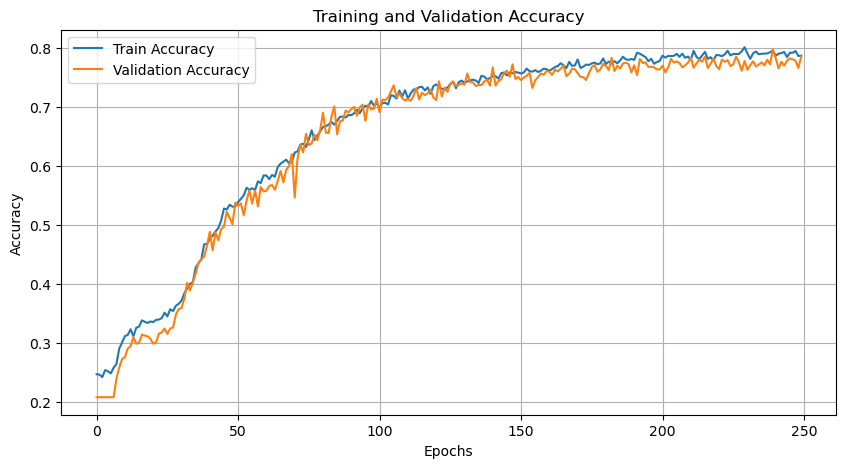

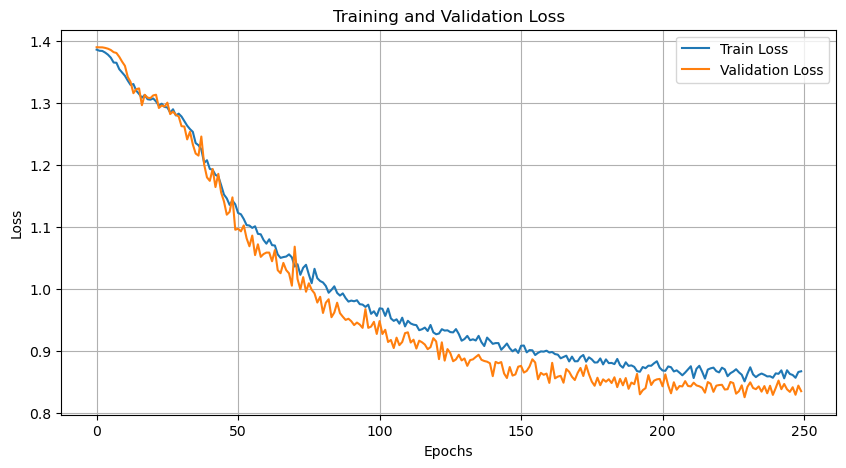

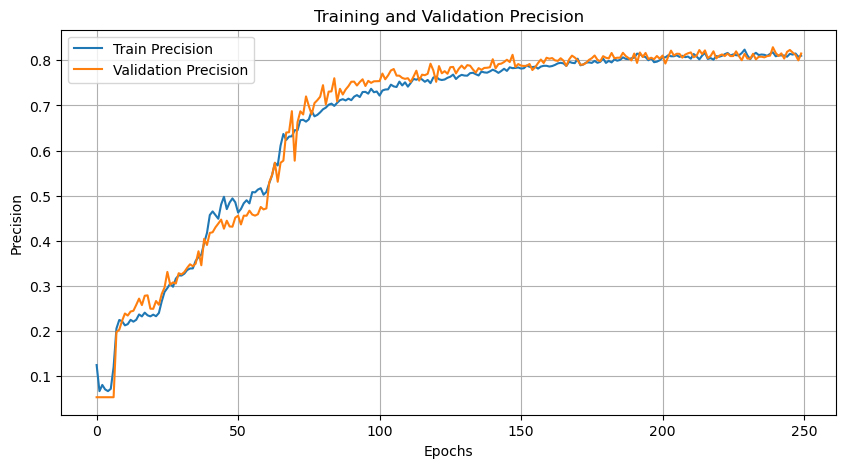

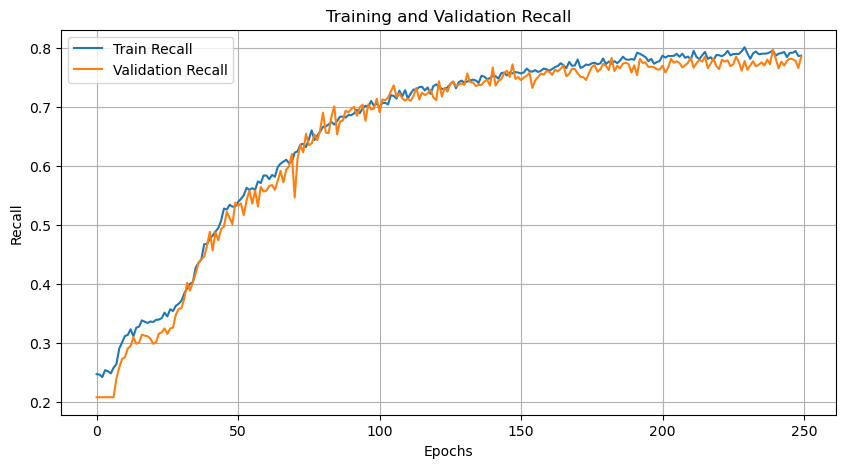

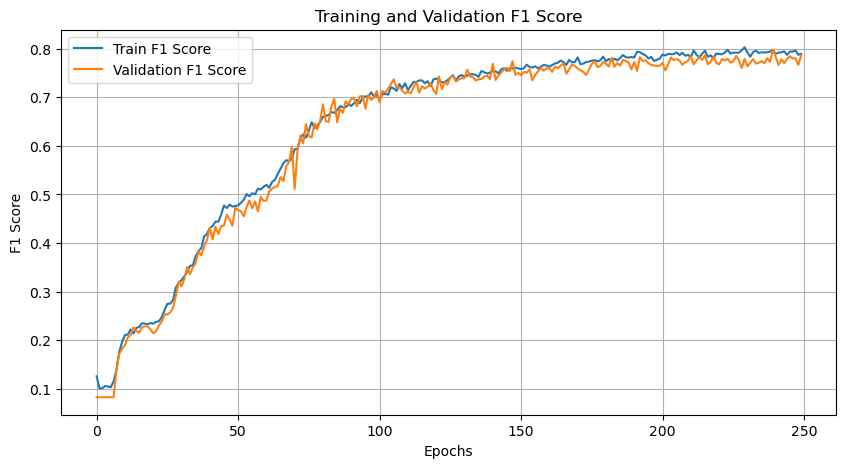

In [24]:
plotter(
    train_metrics["loss"], val_metrics["loss"],
    train_metrics["accuracy"], val_metrics["accuracy"],
    train_metrics["precision"], val_metrics["precision"],
    train_metrics["recall"], val_metrics["recall"],
    train_metrics["f1"], val_metrics["f1"],
    save = save_metrix_img
    )

Отображение Матрицы ошибок

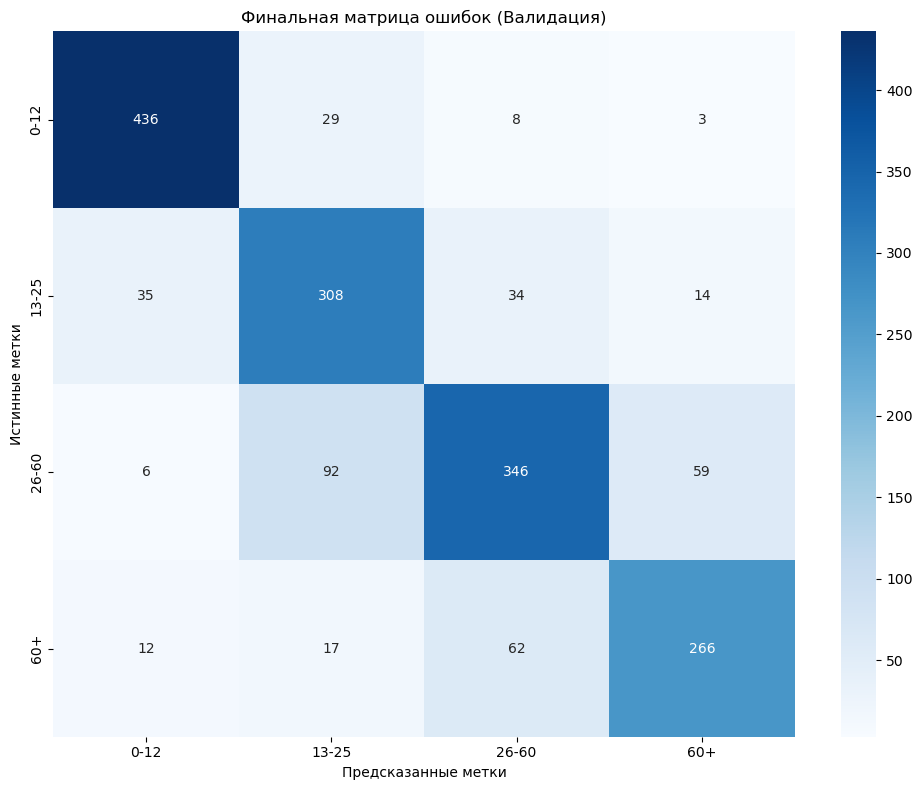

In [25]:
final_val_cm = val_metrics['confusion_matrix'][-1]
plt_final = plot_confusion_matrix(
    final_val_cm, 
    class_names = class_names, 
    title = 'Финальная матрица ошибок (Валидация)',
    save = save_metrix_img
)

## Сохаранение модели

In [ ]:
model_name = r"PATH"

In [27]:
torch.save(model.state_dict(), f'{model_name}.pth')

## Загрузка модели

In [28]:
model = My_Model()
model.load_state_dict(torch.load(f'{model_name}.pth', map_location=device))

<All keys matched successfully>

## Проверка модели

Вспомогательные функции

In [ ]:
# Функция для загрузки и подготовки изображения
def load_image(image_path):
    transform = transforms.Compose([
    transforms.Resize(image_size),  # Изменение размера изображения на 300x300
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)  # Добавляем измерение для батча
    return image

# Функция предсказания
def prediction(model, image_path):
    model = model.cpu()
    image = load_image(image_path).cpu()

    # Прогнозирование
    model.eval()  # Устанавливаем модель в режим оценки
    with torch.no_grad():  # Отключаем градиенты
        image_cpu = image.squeeze(0).cpu()
        plt.imshow(image_cpu.permute(1, 2, 0)*0.5+0.5)
        plt.show()
        
        output = model(image)
        predicted_probabilities = output.cpu().numpy()
        predicted_class = predicted_probabilities.argmax(axis=1)  # Используем argmax для выбора класса с наибольшей вероятностью

    # Вывод предсказанных вероятностей и класса
    print(f"Predicted probabilities: {predicted_probabilities}")
    mass = ["Ребенок", "Подросток", "Взрослый", "Пожилой"]
    print(f"Predicted class (one-hot): {predicted_class[0]}")
    print(mass[predicted_class[0]])